#  Импорт данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit


pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision", 6)
pd.set_option("plotting.backend", "matplotlib")
%matplotlib inline

plt.style.use('default')

# Методы и классы

## Классы регрессии LinearRegression, ElasticRegression, LogisticRegression
Убраны все замыкания

In [2]:
class LinearRegression():
    def __init__(self,
                 learning_rate=0.5,
                 epochs=100,
                 weights=None,
                 bias=None,
                 batch_size=1000,
                 n_batches=None,
                 random_state=42):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = weights
        self.bias = bias
        self.seed = random_state
        self.batch_size = batch_size
        self.cost = np.zeros(epochs)

        self.n_batches = n_batches

        if not (self.weights is None) and self.bias and self.weights[0] != self.bias:
            self.weights = np.append(self.bias, self.weights)

    def forward(self, X):
        return np.dot(X, self.weights)

    def loss(self, yhat, y):
        return np.square(yhat - y).sum() / y.size

    def grad_step(self, yhat, y, X):
        return 2 * np.dot(X.T, (yhat - y)) / y.size

    def update(self):
        return self.weights - self.lr * self.grad

    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size) / np.sqrt(weights_size)

    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()

    def score(self, X, y):
        yhat = self.predict(X)
        return 1 - np.sum(np.square(y - yhat)) / np.sum(np.square(y - np.mean(y)))

    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])

        if self.bias is None:
            self.bias = self.init(1)

        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias, self.weights)

        self.grad = np.zeros(self.weights.shape)
        self.cost = np.zeros(self.epochs)

        if self.batch_size is None:
            self.batch_size = y.size

        if self.n_batches is None:
            self.n_batches = y.size // self.batch_size

        for i in range(self.epochs):
            loss = 0
            for cnt, (x_batch, y_batch) in enumerate(self.load_batch(X, y)):

                yhat = self.forward(x_batch)
                self.grad = self.grad_step(yhat, y_batch, x_batch)
                self.weights = self.update()
                loss += self.loss(yhat, y_batch)

                if cnt >= self.n_batches:
                    break
            self.cost[i] = loss / self.n_batches

        self.bias = self.weights[0]

    def load_batch(self, X, y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0, y.size, self.batch_size):
            idx_batch = idxs[i_batch:i_batch + self.batch_size]
            x_batch = np.take(X, idx_batch, axis=0)
            x_batch = self.add_bias(x_batch)
            y_batch = np.take(y, idx_batch)
            yield x_batch, y_batch

    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    def plot_cost(self, figsize=(12, 6), title=''):
        plt.figure(figsize=figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize=15)
        plt.ylabel('Функция Потерь', fontsize=15)
        if not title:
            title = "График функции потерь"
        plt.title(title, fontsize=24)
        plt.show()

    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

    @staticmethod
    def to_polynom(x, order=2):
        order_range = range(2, order + 1, 1)
        out = np.copy(x)
        for i in order_range:
            out = np.hstack([out, np.power(x, i)])
        return out

    def vis_weigths(self):
        plt.figure(figsize=(12, 6),)
        numbers = np.arange(0, len(self.weights))
        tick_labels = ['w' + str(num) for num in numbers]
        cc = [''] * len(numbers)
        for n, val in enumerate(self.weights):
            if val < 0:
                cc[n] = 'red'
            elif val >= 0:
                cc[n] = 'blue'

        plt.bar(x=numbers, height=self.weights, color=cc)
        plt.title("Веса признаков", fontsize=24)

        plt.yticks(fontsize=15)
        plt.xticks(np.arange(0, len(self.weights)), tick_labels, fontsize=15)
        plt.show()


class ElasticRegression(LinearRegression):
    def __init__(self,
                 learning_rate=0.5,
                 l1_penalty=0.0,
                 l2_penalty=0.0,
                 epochs=100,
                 weights=None,
                 bias=None,
                 batch_size=1000,
                 n_batches=None,
                 random_state=42):
        super().__init__(learning_rate=learning_rate,
                         epochs=epochs,
                         weights=weights,
                         bias=bias,
                         batch_size=batch_size,
                         n_batches=n_batches,
                         random_state=random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

    def loss(self, yhat, y):
        l1_term = self.l1_penalty * np.sum(self.weights[1:]) / y.size
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weights[1:])) / y.size
        return np.square(yhat - y).mean() + l1_term + l2_term

    def update(self):
        l2_term = self.l2_penalty * np.sum(self.weights[1:])
        return self.weights - self.lr * (self.grad + np.sign(self.weights) * self.l1_penalty + l2_term)


class LogisticRegression(ElasticRegression):
    def __init__(self,
                 learning_rate=0.5,
                 l1_penalty=0.0,
                 l2_penalty=0.0,
                 epochs=100,
                 weights=None,
                 bias=None,
                 threshold=0.5,
                 batch_size=1000,
                 n_batches=None,
                 random_state=42,
                 EPS=1e-6):

        super().__init__(learning_rate=learning_rate,
                         epochs=epochs,
                         weights=weights,
                         bias=bias,
                         batch_size=batch_size,
                         n_batches=n_batches,
                         random_state=random_state,
                         l1_penalty=l1_penalty,
                         l2_penalty=l2_penalty)
        self.learning_rate = learning_rate / 2
        self.threshold = threshold
        self.EPS = EPS

    def loss(self, yhat, y):

        l1_term = self.l1_penalty * np.sum(self.weights[1:])
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weights[1:]))

        return -(y * np.log(yhat + self.EPS) + (1 - y) * np.log(1 - yhat + self.EPS)).mean() \
            + l1_term + l2_term

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def forward(self, X):
        return self.sigmoid(np.dot(X, self.weights))

    def to_class(self, logit):
        return (logit >= self.threshold) * 1

    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat

    def score(self, X, y):
        yhat = self.predict(X)
        return sum((yhat == y) * 1) / y.size

    def plot_desicion_function(self, X, y, figsize=(12, 6),
                               marker='o', colors=("#FF0000", '#0000FF'),
                               alpha=0.7, s=150, poly=False, order=2):
        print("Функция принятия решений")
        plt.figure(figsize=figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1], marker=marker, c=y, cmap=cm_bright, s=s, alpha=alpha);
        h = (X[:, 0].max() - X[:, 0].min()) / 50
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict_prob(self.to_polynom(np.c_[xx.ravel(), yy.ravel()], order)) - 0.5
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()]) - 0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.tight_layout()
        plt.show()

    def classification_report(self, X, y):
        tp = 0  # true_positives
        tn = 0  # true_negatives
        fp = 0  # false_positives
        fn = 0  # false_negatives

        yhat = self.predict(X)
        total = yhat.size
        n = sum(yhat == 0)
        p = sum(yhat == 1)

        for yhati, yi in zip(yhat, y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('Метрики классификации')
        print('True Positives:%.4f' % (tp / p), end='\t')
        print('True Negatives:%.4f' % (tn / n))
        print('False Positives:%.4f' % (fp / p), end='\t')
        print('False Negatives:%.4f' % (fn / n))
        print('Accuracy:%.4f' % ((tp + tn) / total))
        print('Recall:%.4f' % (tp / (tp + fn)), end='\t')
        print('Precision:%.4f' % (tp / (tp + fp)))
        print('f1 measure:%.4f' % (tp / (tp + 0.5 * (fp + fn))))

    def classify(self, x, y, title, polynom_order = None):
        print(title)
        x_count = x.shape[1]

        if polynom_order and polynom_order >= 2:
            x = self.to_polynom(x, order = polynom_order)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=self.seed)
        fig = plt.figure(figsize=(30, 8))
        ax = plt.subplot(1, 2, 1)
        plot_data(ax, (x_train, y_train), 'Тренировочные данные')
        ax = plt.subplot(1, 2, 2)
        plot_data(ax, (x_test, y_test), 'Тестовые данные')
        plt.show()

        self.fit(x_train, y_train)
        self.plot_cost()
        self.vis_weigths()
        print('Accuracy:')
        print("Для тренировочной выборки", self.score(x_train, y_train))
        print("Для тестовой выборки", self.score(x_test, y_test))
        self.classification_report(x_test, y_test)
        if x_count<2:
            if polynom_order and polynom_order >= 2:
                self.plot_desicion_function(x, y, poly=True, order=polynom_order)
            else:
                self.plot_desicion_function(x, y)


## Методы визуализации

In [3]:
def plot_data(ax, ds, name='', marker='o', colors=("#FF0000", '#0000FF'), alpha=0.7, s=150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize=30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker=marker, c=y,
                   cmap=cm_bright, s=s,
                   alpha=alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker=marker, c=y,
                   cmap=cm_bright, s=s,
                   facecolor='None',
                   alpha=alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

## Методы генерации данных

In [4]:
def make_binary_clf(N, method='line',
                    noises=0.15,
                    random_state=42):
    if random_state: rng = np.random.RandomState(seed=random_state)

    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) * noises
        out = (X, y)

    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises,
                          random_state=random_state)

    elif method == 'circles':
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state)

    return X, y

# Логистическая регрессия для синтетических данных
## Генерация данных

In [5]:
N = 150  # @param {type:"slider", min:50, max:250, step:25}

moons_data = make_binary_clf(N, method='moons', noises=0.2)
circles_data = make_binary_clf(N, method='circles', noises=0.2)

## Графики сгенерированных данных

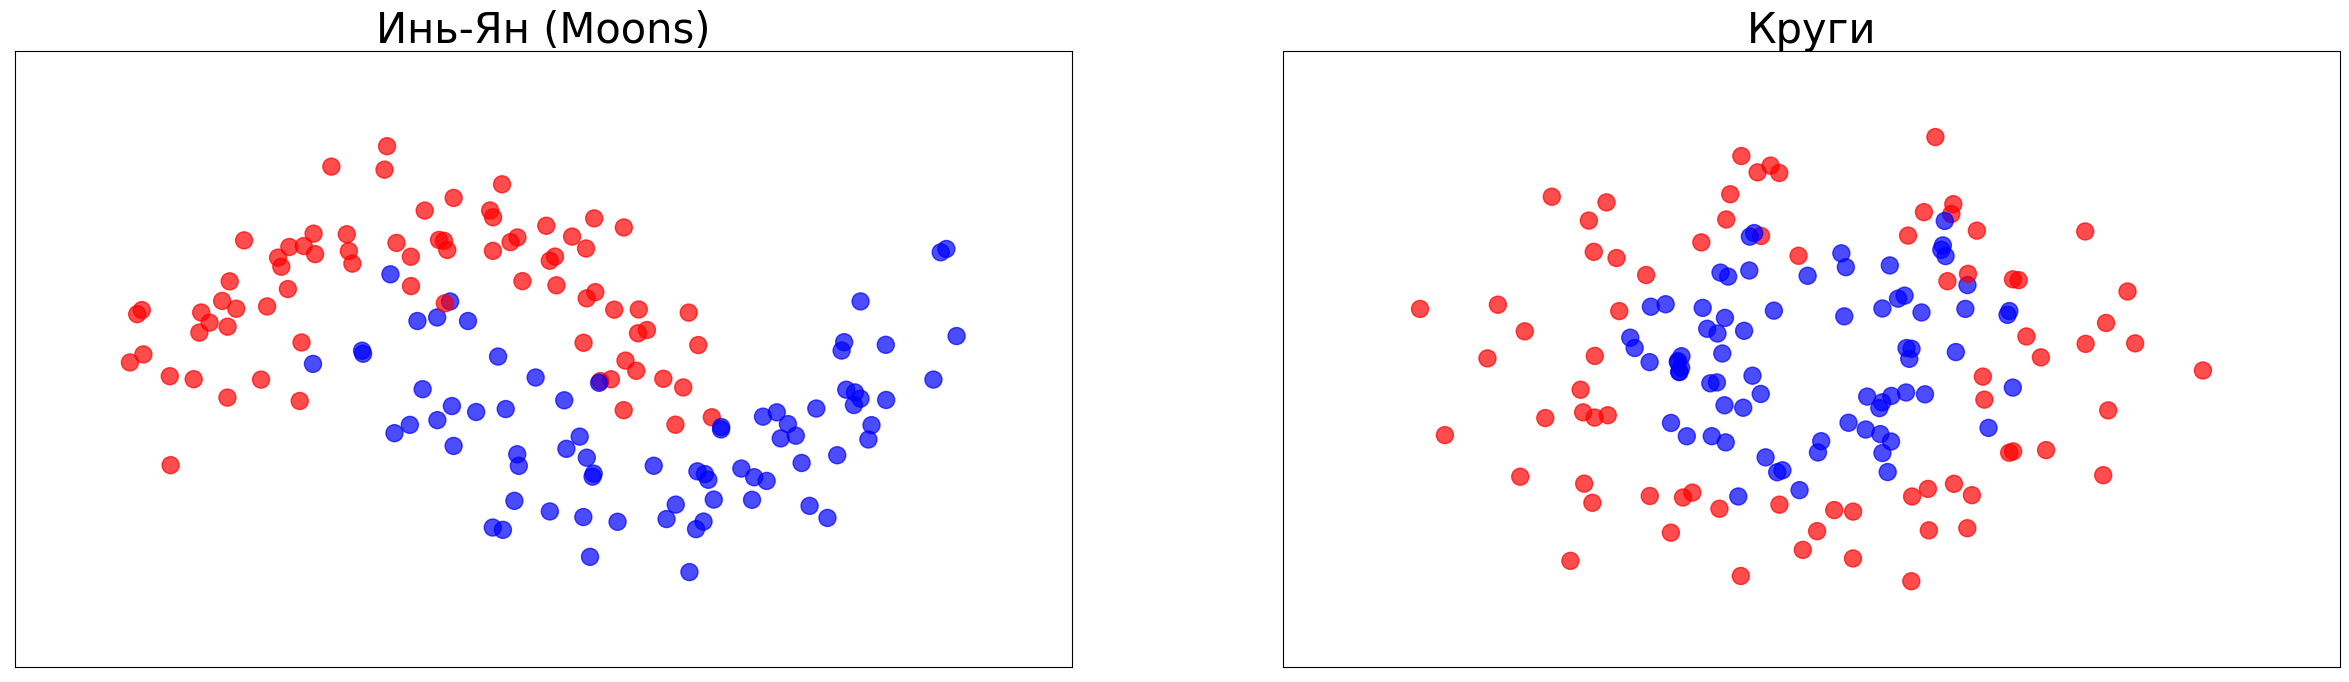

In [6]:
fig = plt.figure(figsize=(30, 8))

ax = plt.subplot(1, 2, 1)
plot_data(ax, moons_data, 'Инь-Ян (Moons)')
ax = plt.subplot(1, 2, 2)
plot_data(ax, circles_data, 'Круги')
plt.show()

## Классификация данных
### Классификация данных, распределенных как знак Инь-Ян, с использованием линейной модели без регуляризации

Классификация данных, распределенныхкак знак Инь-Ян, с использованием линейной модели без регуляризации


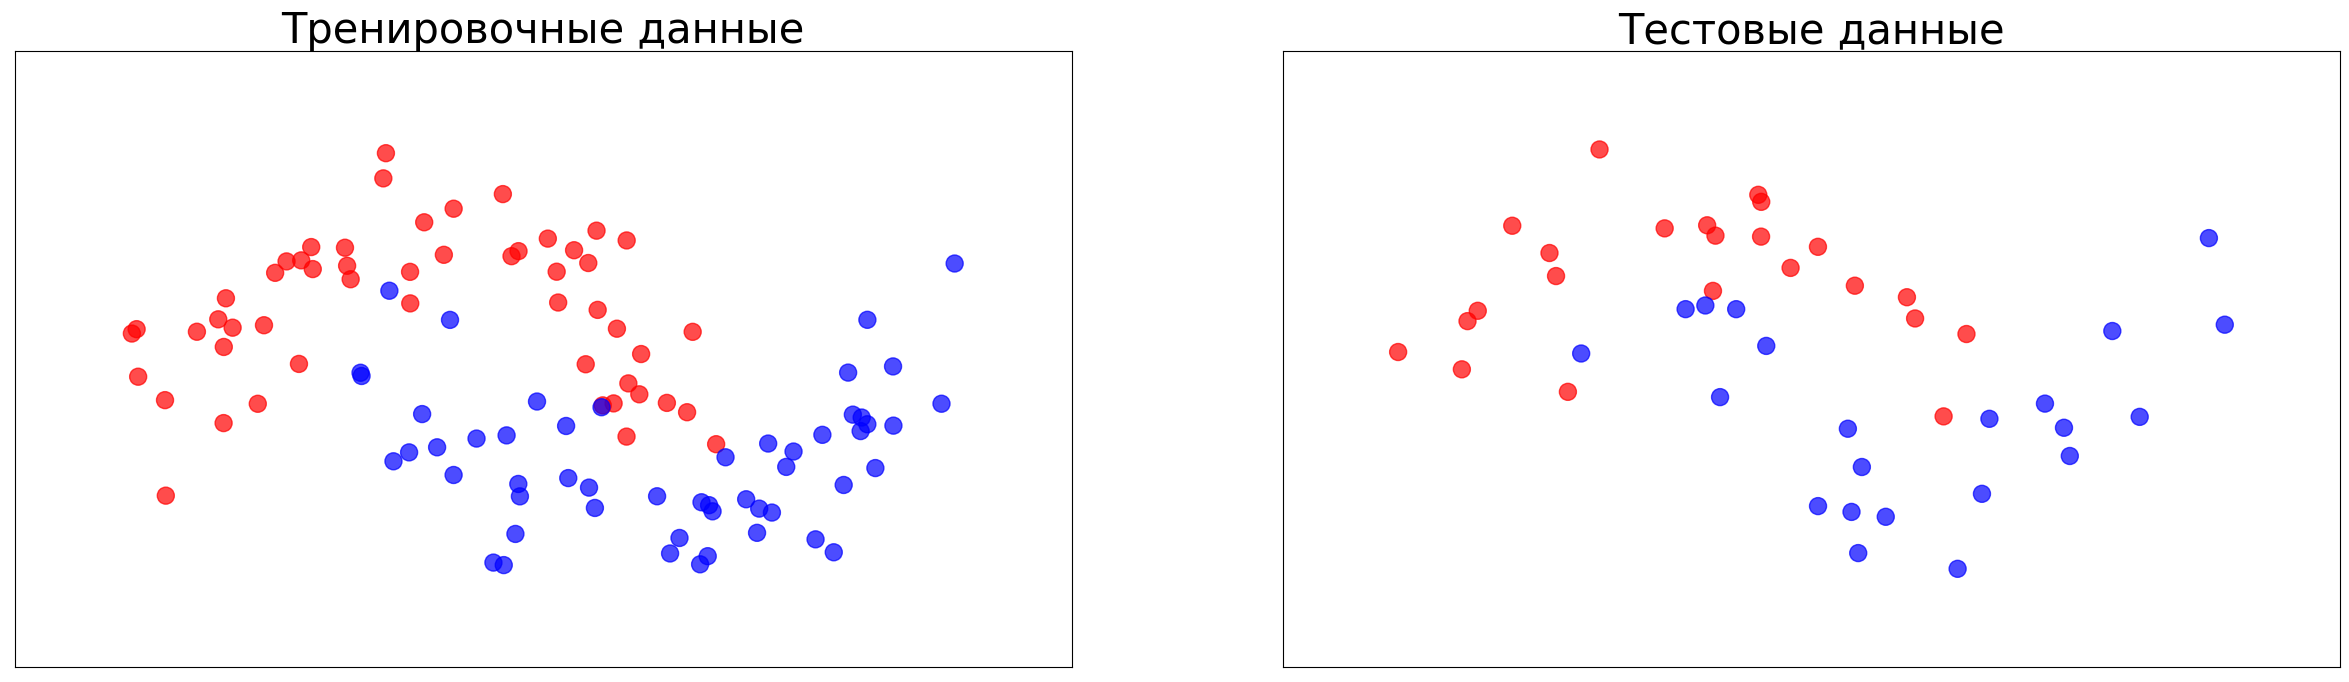

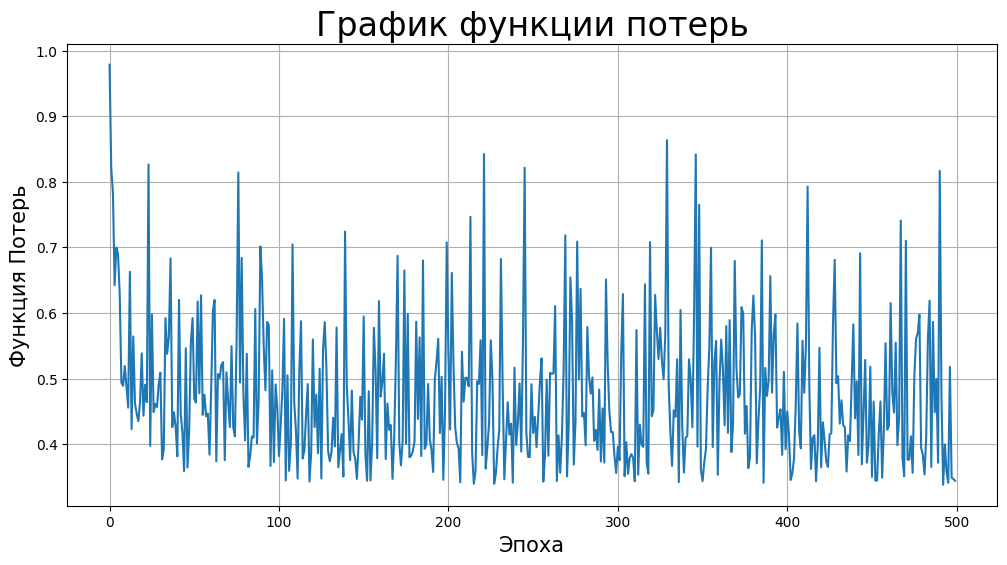

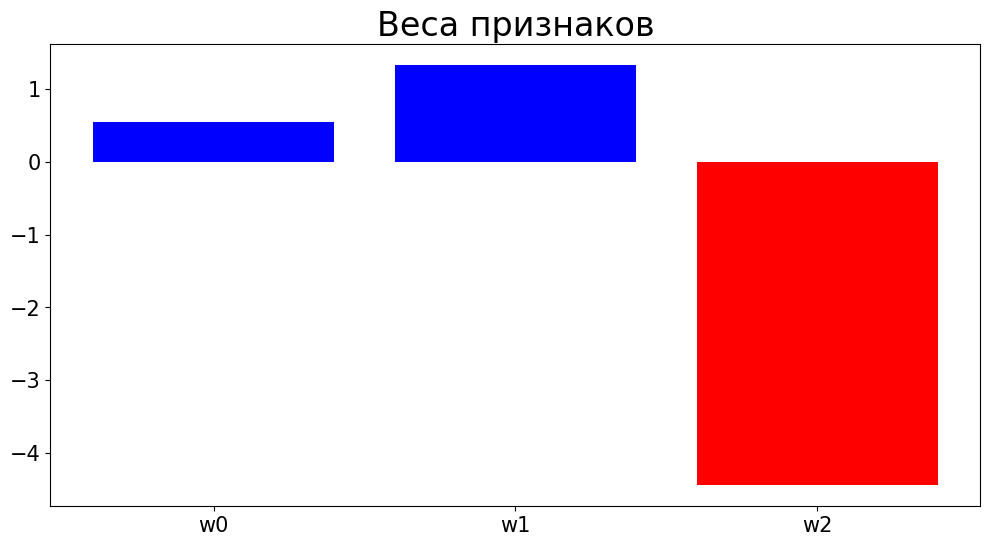

Accuracy:
Для тренировочной выборки 0.8571428571428571
Для тестовой выборки 0.8222222222222222
Метрики классификации
True Positives:0.8889	True Negatives:0.7778
False Positives:0.1111	False Negatives:0.2222
Accuracy:0.8222
Recall:0.7273	Precision:0.8889
f1 measure:0.8000


In [7]:
regr1 = LogisticRegression(learning_rate=0.25, epochs=500, batch_size=50, )
regr1.classify(*moons_data, "Классификация данных, распределенных"
                            "как знак Инь-Ян, с использованием линейной модели без регуляризации")

#### Анализ
Функция потерь не сходится, ее минимальное значение далеко от 0, много пропусков и ложных срабатываний, метрики невысокие.
Вывод: данный метод не подходит для классификации данных, распределенных как знак Инь-Ян.

### Классификация данных, распределенных как знак Инь-Ян, с использованием полиномиальной модели без регуляризации

Классификация данных, распределенныхкак знак Инь-Ян, с использованием полиномиальной модели без регуляризации


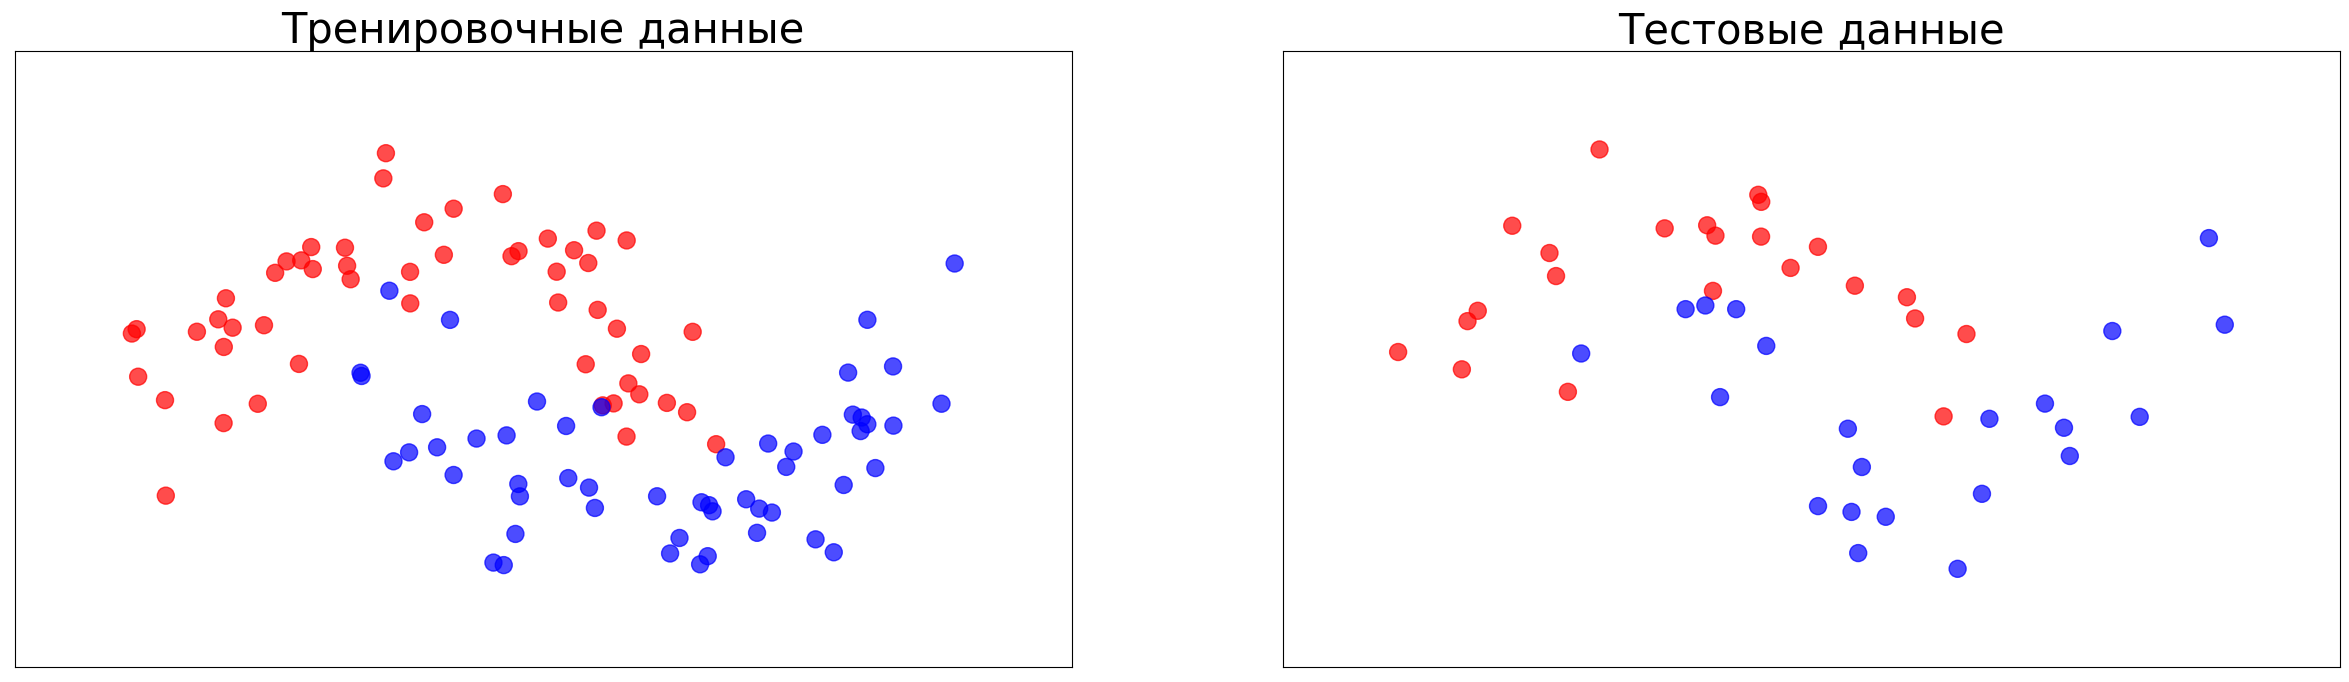

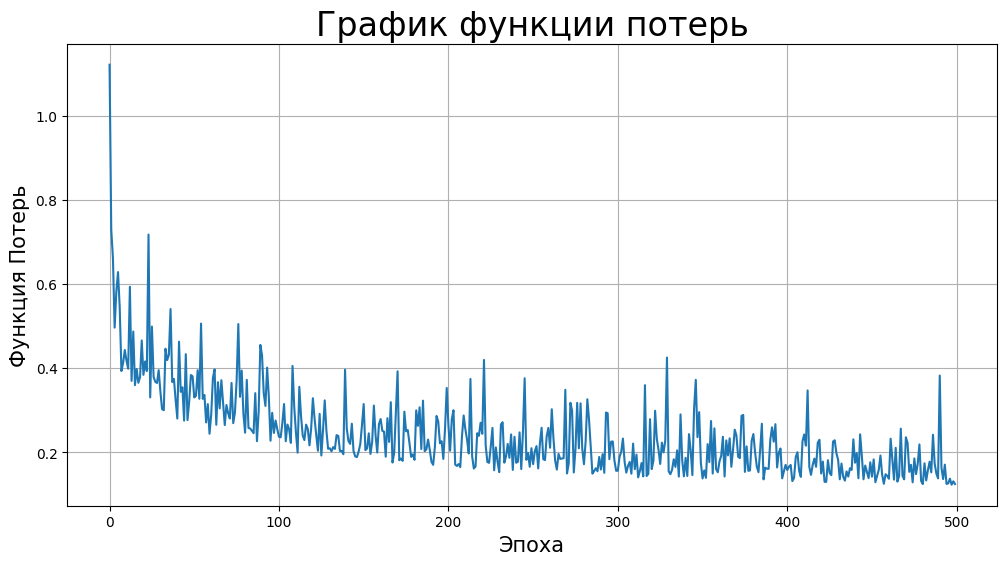

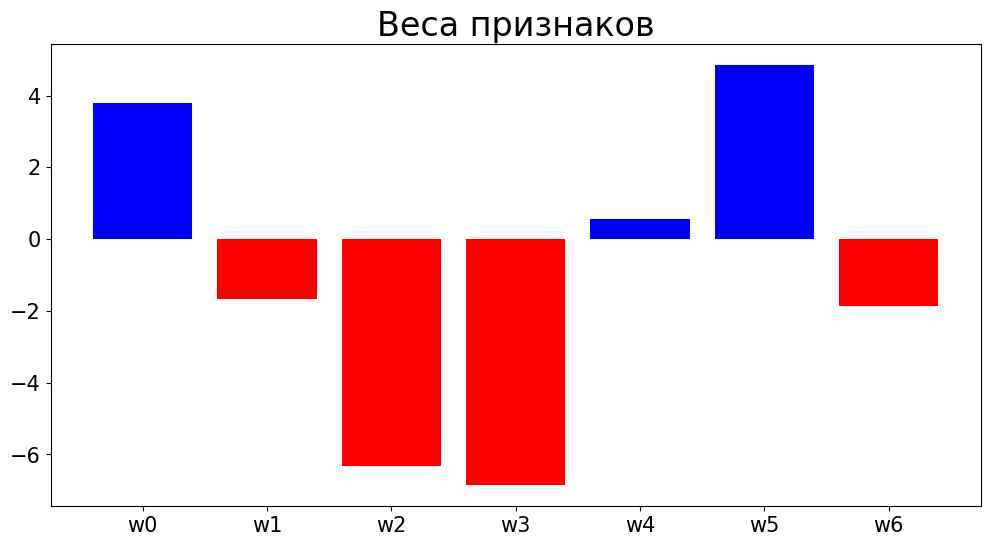

Accuracy:
Для тренировочной выборки 0.9523809523809523
Для тестовой выборки 0.9555555555555556
Метрики классификации
True Positives:0.9167	True Negatives:1.0000
False Positives:0.0833	False Negatives:0.0000
Accuracy:0.9556
Recall:1.0000	Precision:0.9167
f1 measure:0.9565


In [8]:
regr2 = LogisticRegression(learning_rate=0.25, epochs=500, batch_size=50, )
regr2.classify(*moons_data, "Классификация данных, распределенных"
                            "как знак Инь-Ян, с использованием полиномиальной модели без регуляризации", 3)

#### Анализ
В качестве модели использовался полином 3-й степени.
Функция потерь очень медленно сходится, стремится к 0, нет пропусков, ложных срабатываний немного, метрики достаточно высокие, близки к 1.
Вывод: данный метод хорошо подходит для классификации данных, распределенных как знак Инь-Ян.

### Классификация данных, распределенных как знак Инь-Ян, с использованием полиномиальной модели с регуляризацией

Классификация данных, распределенныхкак знак Инь-Ян, с использованием полиномиальной модели с регуляризацией


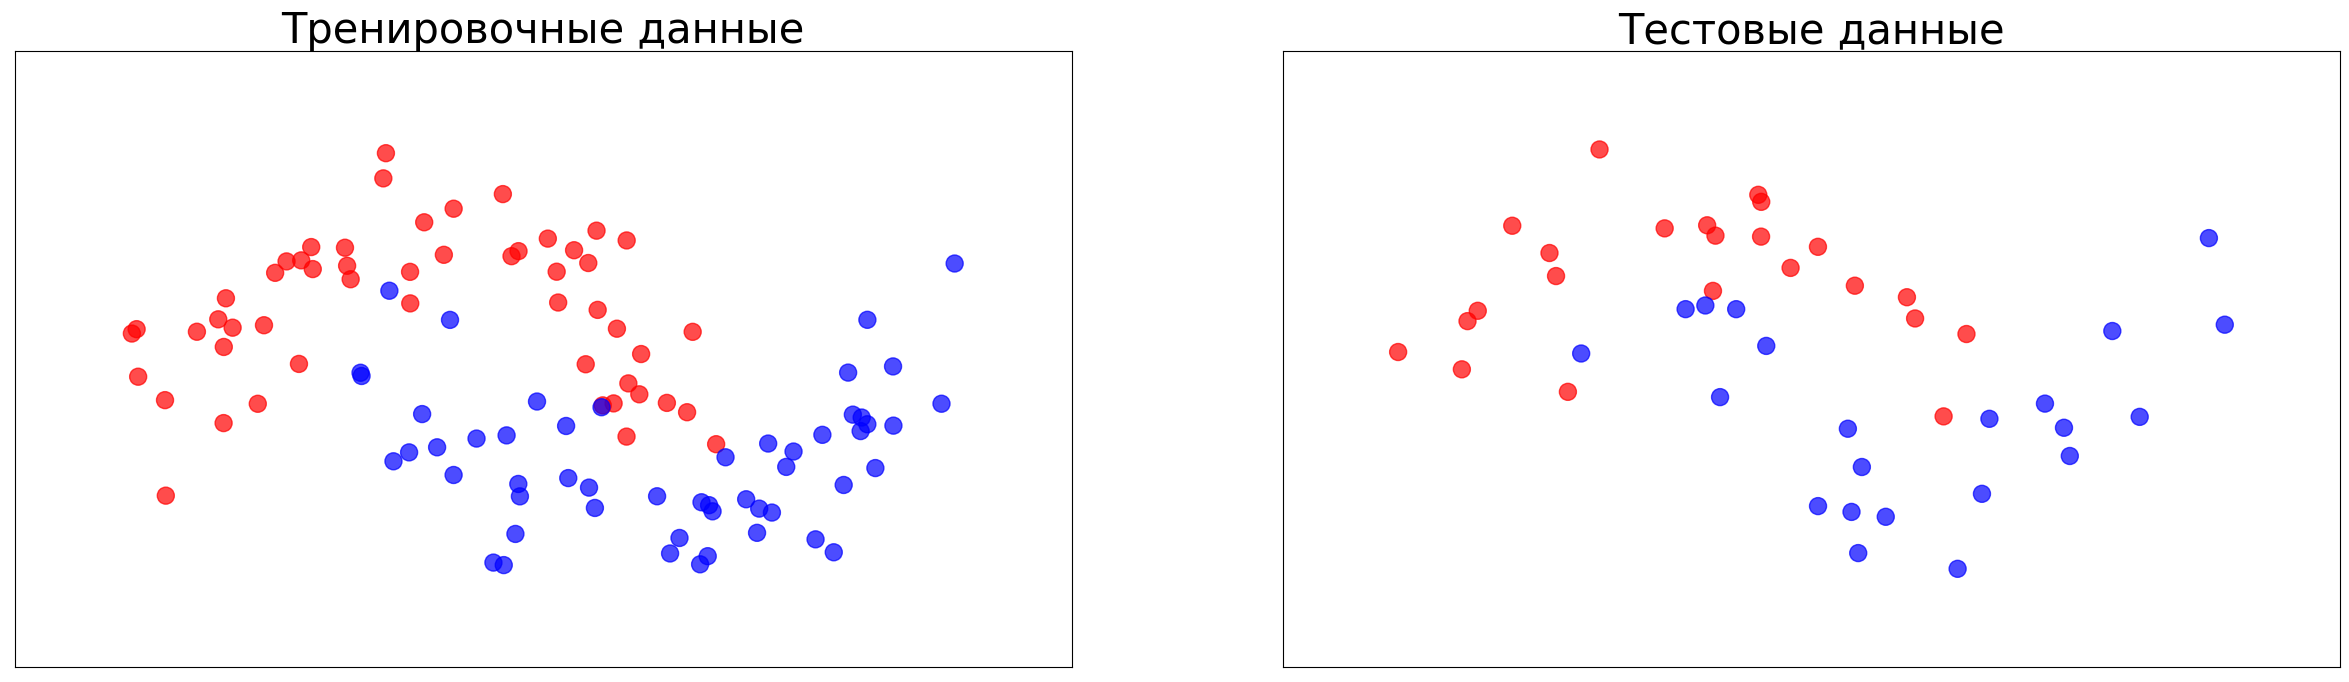

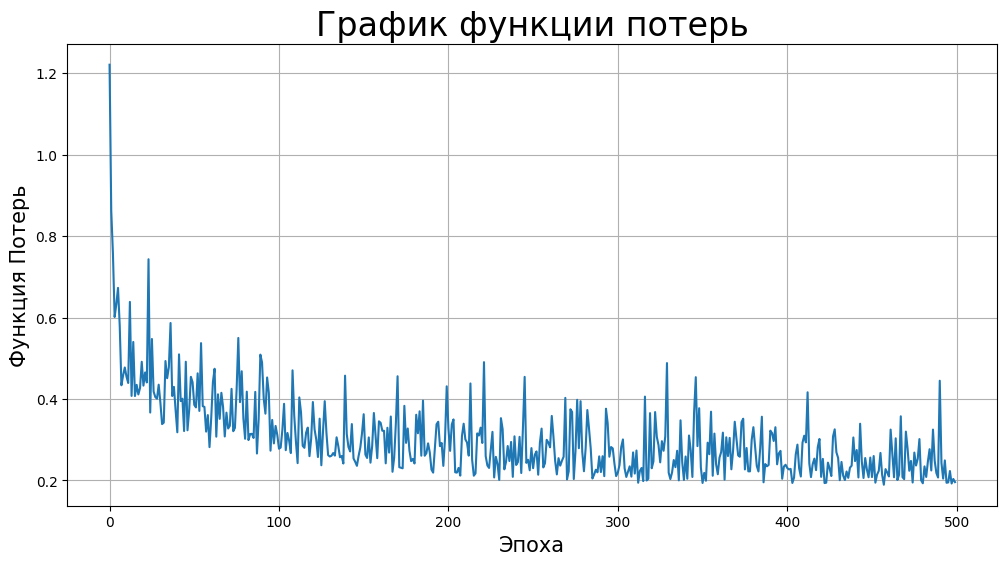

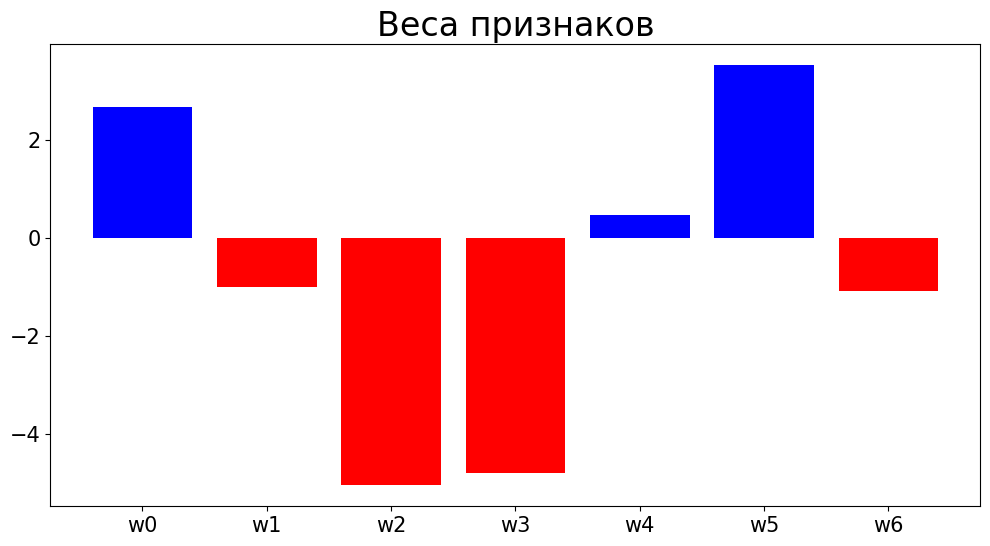

Accuracy:
Для тренировочной выборки 0.9523809523809523
Для тестовой выборки 0.9111111111111111
Метрики классификации
True Positives:0.9091	True Negatives:0.9130
False Positives:0.0909	False Negatives:0.0870
Accuracy:0.9111
Recall:0.9091	Precision:0.9091
f1 measure:0.9091


In [9]:
regr3 = LogisticRegression(learning_rate=0.15, epochs=500, batch_size=50,   l1_penalty=.001, l2_penalty=.001)
regr3.classify(*moons_data, "Классификация данных, распределенных"
                            "как знак Инь-Ян, с использованием полиномиальной модели с регуляризацией", 3)

#### Анализ
В качестве модели использовался полином 3-й степени и эластичная регуляризация.
Функция потерь очень медленно сходится, но не к 0, есть пропуски и ложные срабатывания, метрики достаточно высокие, но они хуже, чем при классификации без  регуляризации.
Вывод: данный метод не подходит для классификации данных, распределенных как знак Инь-Ян.

### Классификация данных, распределенных как круги, с использованием линейной модели без регуляризации

Классификация данных, распределенныхкаккруги, с использованием линейной модели без регуляризации


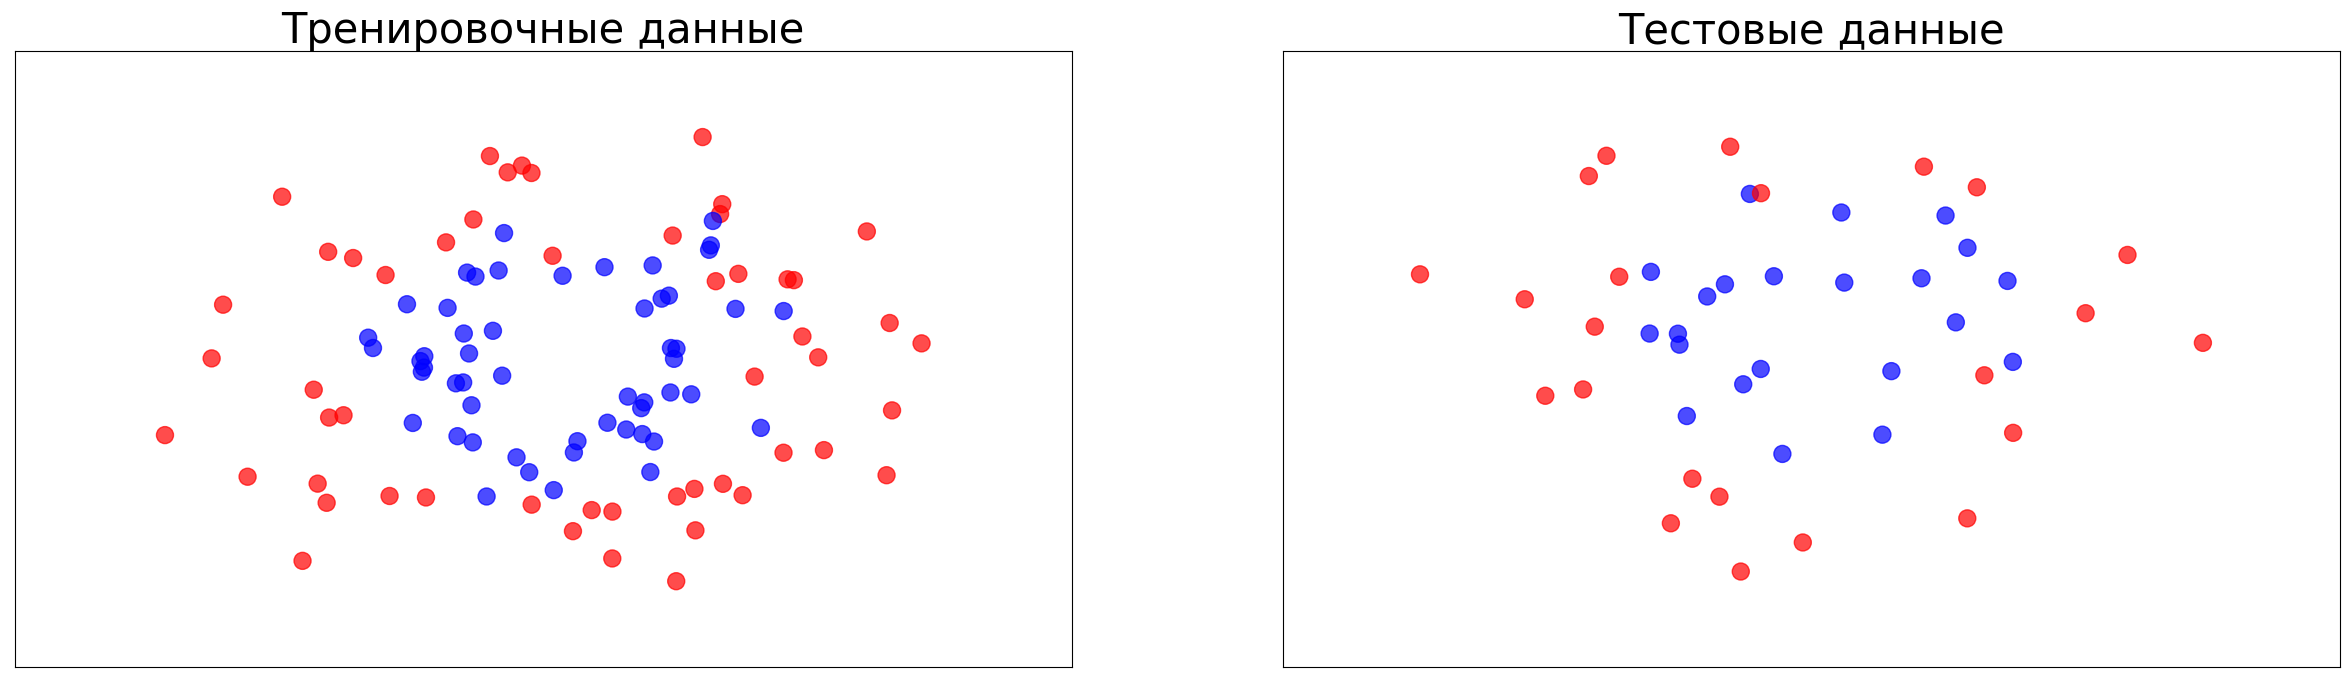

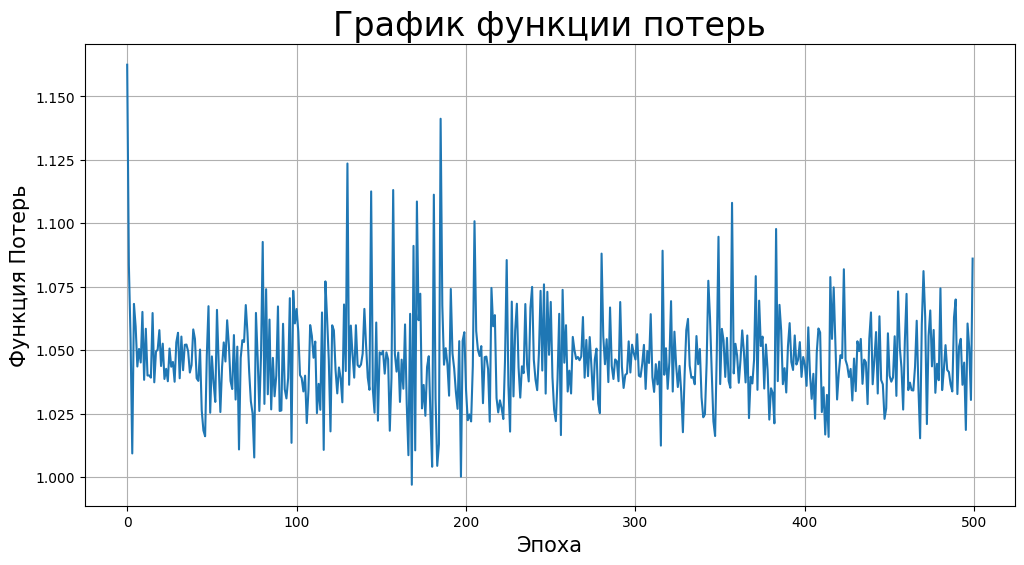

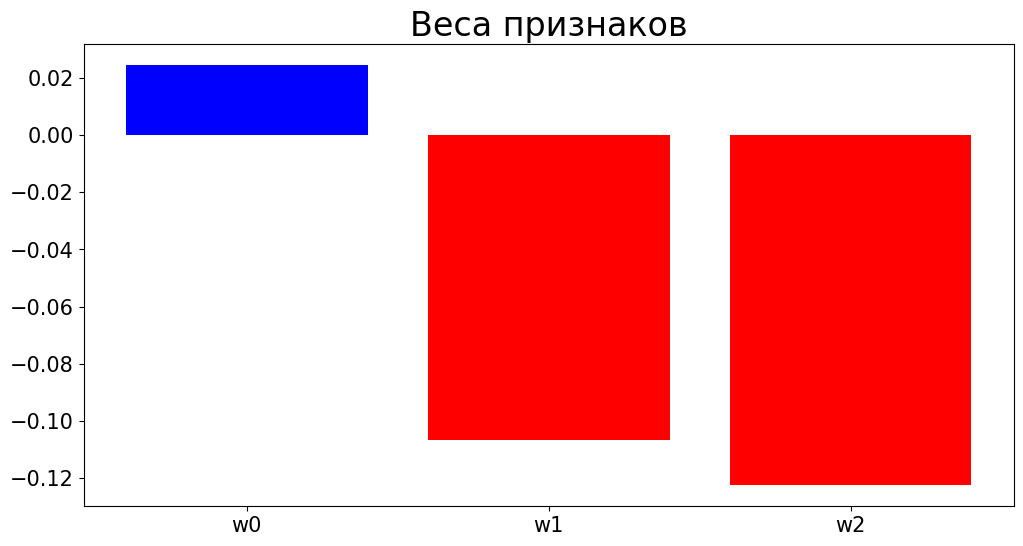

Accuracy:
Для тренировочной выборки 0.5523809523809524
Для тестовой выборки 0.4666666666666667
Метрики классификации
True Positives:0.4615	True Negatives:0.4737
False Positives:0.5385	False Negatives:0.5263
Accuracy:0.4667
Recall:0.5455	Precision:0.4615
f1 measure:0.5000


In [10]:
regr4 = LogisticRegression(learning_rate=0.25, epochs=500, batch_size=50, )
regr4.classify(*circles_data, "Классификация данных, распределенных"
                            "каккруги, с использованием линейной модели без регуляризации")

#### Анализ
Функция потерь не сходится, ее минимальное значение далеко от 0, много пропусков и ложных срабатываний, метрики очень низкие. Эффективность метода блика к бросанию монеты.
Вывод: данный метод не подходит для классификации данных, распределенных как круги.

### Классификация данных, распределенных как круги, с использованием полиномиальной модели без регуляризации

Классификация данных, распределенныхкак круги, с использованием полиномиальной модели без регуляризации


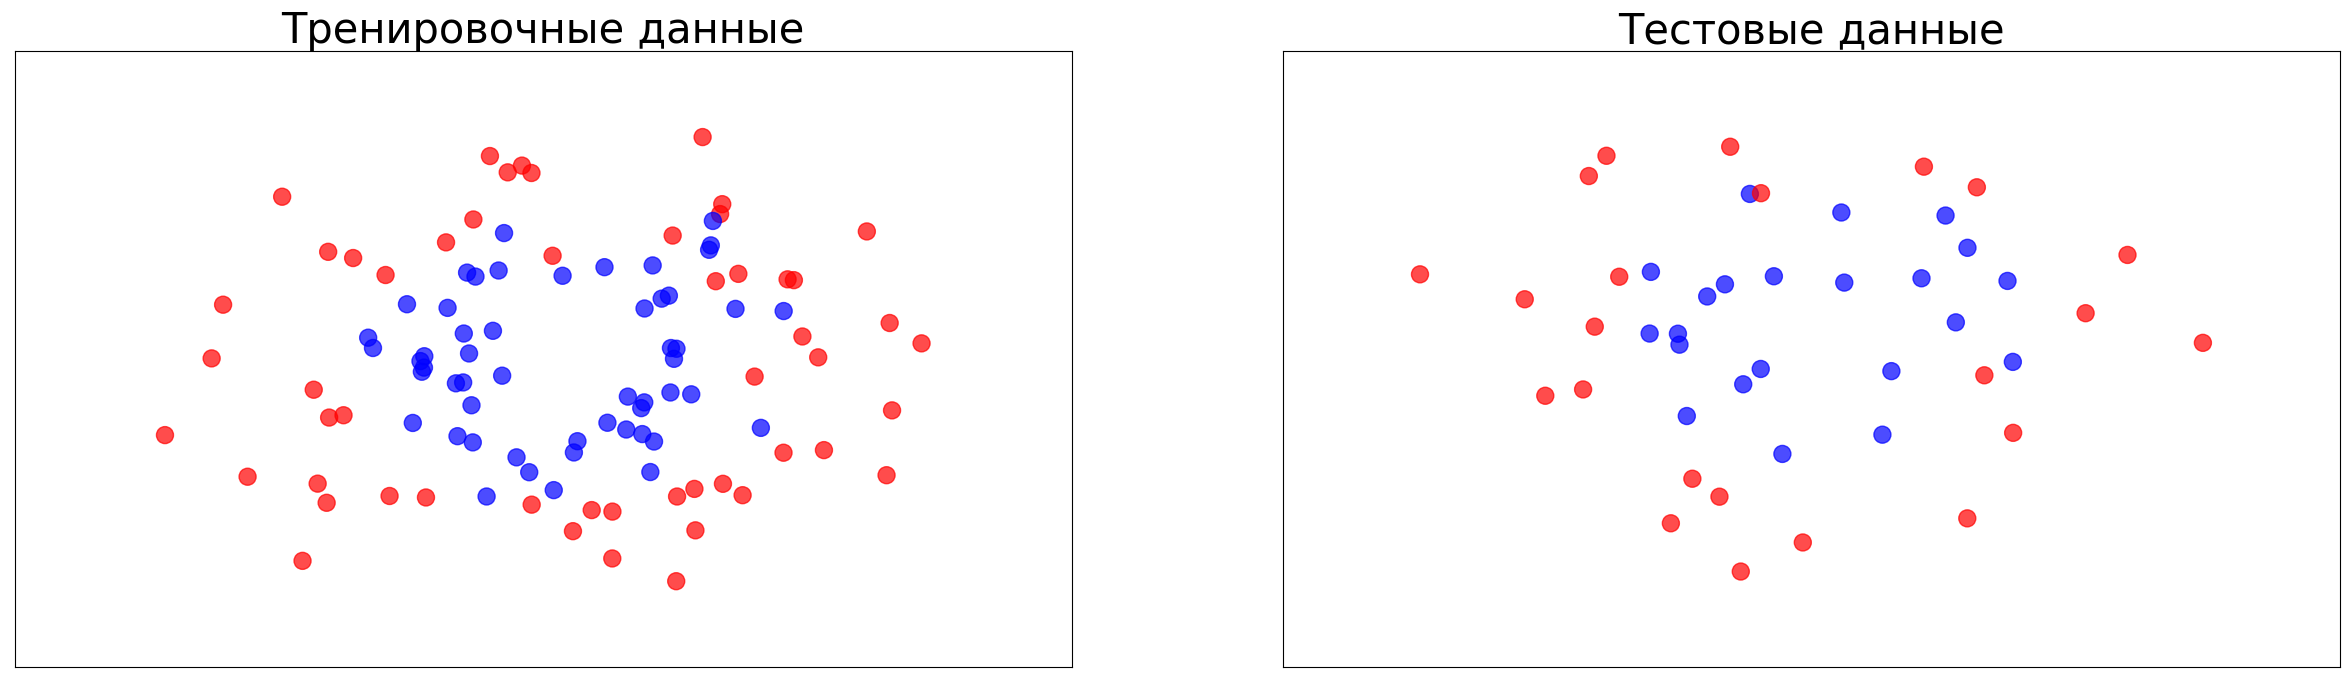

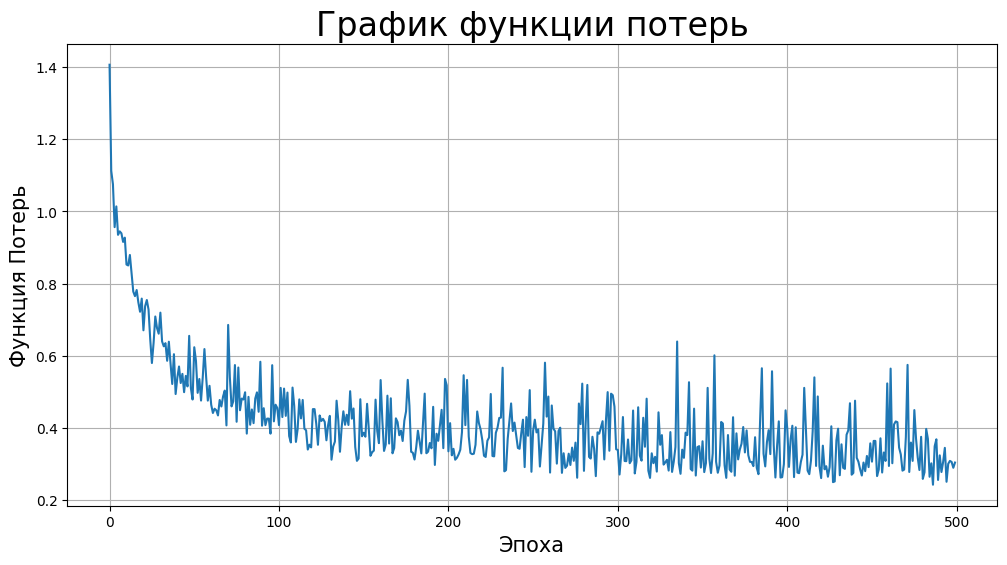

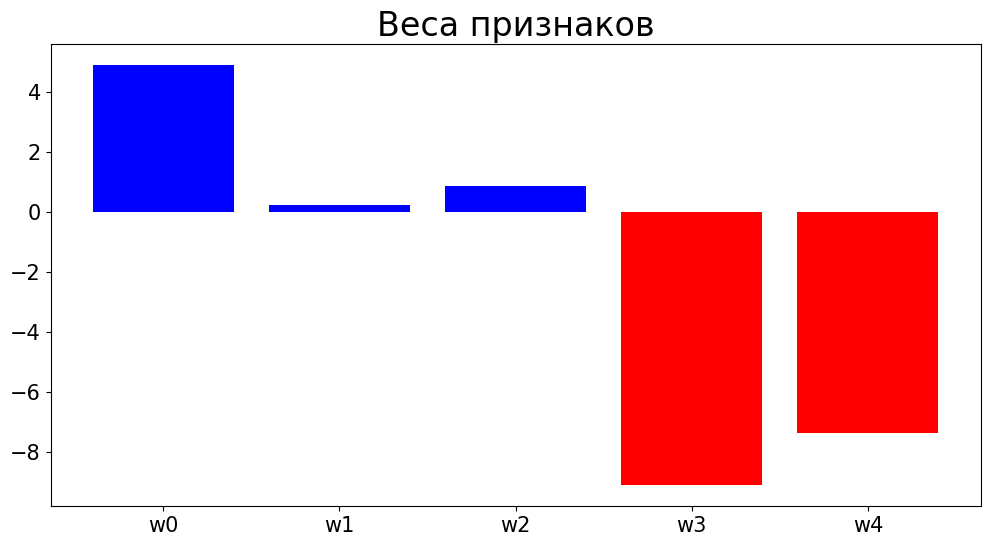

Accuracy:
Для тренировочной выборки 0.9047619047619048
Для тестовой выборки 0.8888888888888888
Метрики классификации
True Positives:0.9048	True Negatives:0.8750
False Positives:0.0952	False Negatives:0.1250
Accuracy:0.8889
Recall:0.8636	Precision:0.9048
f1 measure:0.8837


In [11]:
regr5 = LogisticRegression(learning_rate=0.25, epochs=500, batch_size=50, )
regr5.classify(*circles_data, "Классификация данных, распределенных"
                            "как круги, с использованием полиномиальной модели без регуляризации", 2)

#### Анализ
В качестве модели использовался полином 2-й степени.
Функция потерь очень медленно сходится, есть немного пропусков и ложных срабатываний, метрики достаточно высокие, близки к 0,9.
Вывод: данный метод можно использовать для классификации данных, распределенных как круги.

### Классификация данных, распределенных как знак Инь-Ян, с использованием полиномиальной модели с регуляризацией

Классификация данных, распределенныхкак круги, с использованием полиномиальной модели с регуляризацией


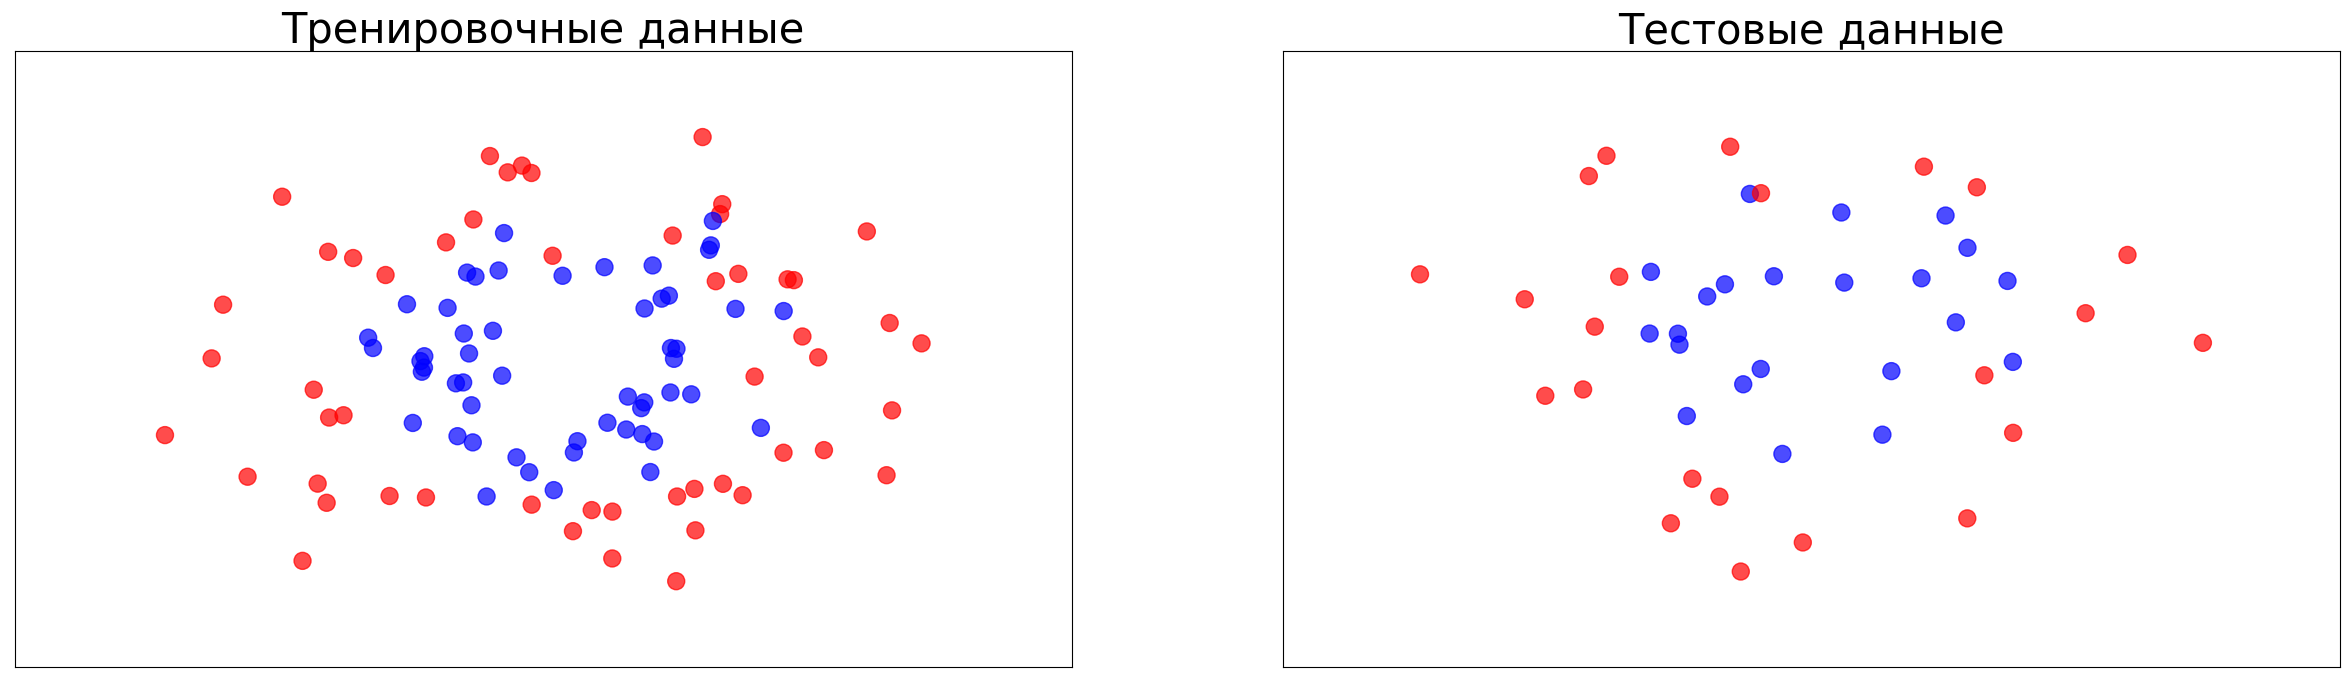

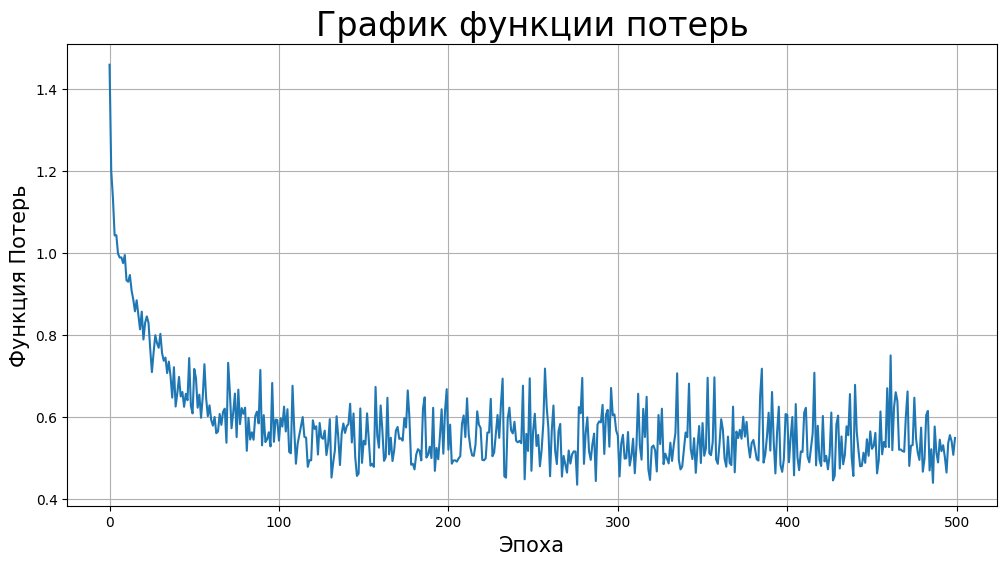

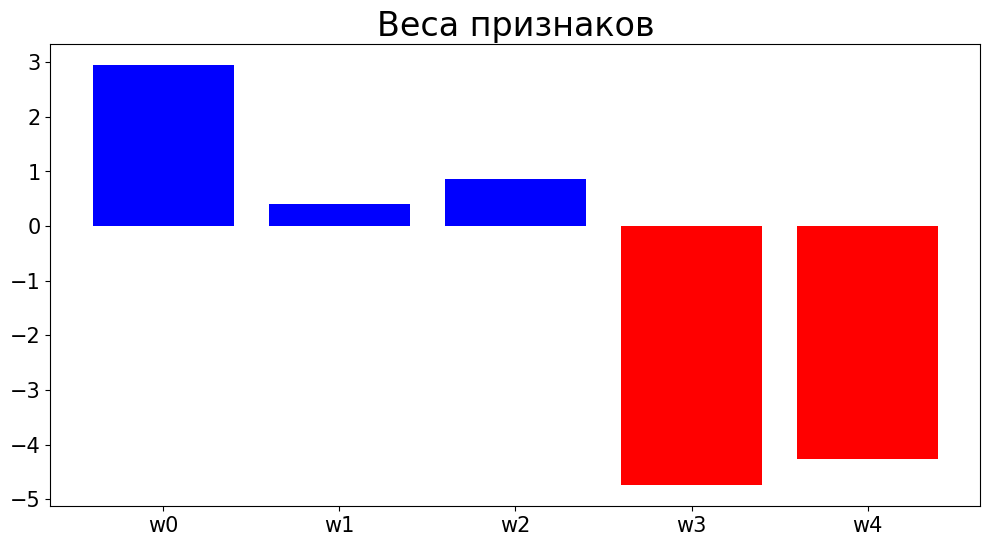

Accuracy:
Для тренировочной выборки 0.9047619047619048
Для тестовой выборки 0.9333333333333333
Метрики классификации
True Positives:0.8800	True Negatives:1.0000
False Positives:0.1200	False Negatives:0.0000
Accuracy:0.9333
Recall:1.0000	Precision:0.8800
f1 measure:0.9362


In [12]:
regr6 = LogisticRegression(learning_rate=0.15, epochs=500, batch_size=50,   l1_penalty=.005, l2_penalty=.005)
regr6.classify(*circles_data, "Классификация данных, распределенных"
                            "как круги, с использованием полиномиальной модели с регуляризацией", 2)


#### Анализ
В качестве модели использовался полином 2-й степени  и эластичная регуляризация.
Функция потерь очень медленно сходится, есть немного ложных срабатываний, нет пропусков, метрики достаточно высокие, выше, чем при классификации без регуляризации.
Вывод: данный метод можно рекомендовать как предпочтительный для классификации данных, распределенных как круги.


# Логистическая регрессия для набора данных Cars Moldova (предсказание типа трансмиссии автомобилей на вторичном рынке Молдавии)


## Логистическая регрессия при использовании стандартизации  для числовых признаков
### Загрузка данных

In [13]:
# Загрузка числовых стандартизованных данных
df = pd.read_csv('./content/cars_moldova_hw1_df_standard.csv', delimiter = ',')
df.tail()

Distance  Engine_capacity(cm3)  Price(euro)       Age
32913  0.528012             -0.156758    -0.579039  0.866971
32914 -0.858773             -0.686971    -0.243899 -0.954742
32915 -1.764008             -0.686971    -0.566149 -0.113951
32916  2.006570              0.196717    -0.630599  0.306444
32917  1.292784             -0.686971    -0.630599  0.306444

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32918 entries, 0 to 32917
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Distance              32918 non-null  float64
 1   Engine_capacity(cm3)  32918 non-null  float64
 2   Price(euro)           32918 non-null  float64
 3   Age                   32918 non-null  float64
dtypes: float64(4)
memory usage: 1.0 MB


Определяем числовые столбцы

In [15]:
num_columns = df.columns
num_columns

Index(['Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'Age'], dtype='object')

Загрузка категориальных кодированных данных

In [16]:
df_ne = pd.read_csv('./content/cars_moldova_hw1_numeric_encoded.csv', delimiter = ',')
df_ne.tail()

Model  Make  Style  Brand_country  Age_group  Wear  Fuel_type_Diesel  \
32913     26    10      3              2          3     3                 0   
32914     23     4     11              2          1     1                 1   
32915     26    20      4              2          2     0                 1   
32916     26    12      1              3          2     5                 1   
32917     19    20      6              2          2     4                 1   

       Fuel_type_Electric  Fuel_type_Hybrid  Fuel_type_Metan/Propan  \
32913                   0                 0                       1   
32914                   0                 0                       0   
32915                   0                 0                       0   
32916                   0                 0                       0   
32917                   0                 0                       0   

       Fuel_type_Petrol  Fuel_type_Plug-in Hybrid  Transmission_Manual  
32913                 0                         0                    1  
32914                 0                         0                    1  
32915                 0                         0                    1  
32916                 0                         0                    1  
32917                 0                         0                    1

Определяем категориальные столбцы

In [17]:
cat_columns = df_ne.columns
cat_columns

Index(['Model', 'Make', 'Style', 'Brand_country', 'Age_group', 'Wear',
       'Fuel_type_Diesel', 'Fuel_type_Electric', 'Fuel_type_Hybrid',
       'Fuel_type_Metan/Propan', 'Fuel_type_Petrol',
       'Fuel_type_Plug-in Hybrid', 'Transmission_Manual'],
      dtype='object')

Определение данных

In [18]:
x = df.values
y = df_ne["Transmission_Manual"].values

### Классификация данных с использованием линейной модели без регуляризации

Классификация данных Cars Moldova, с использованием линейной модели без регуляризации


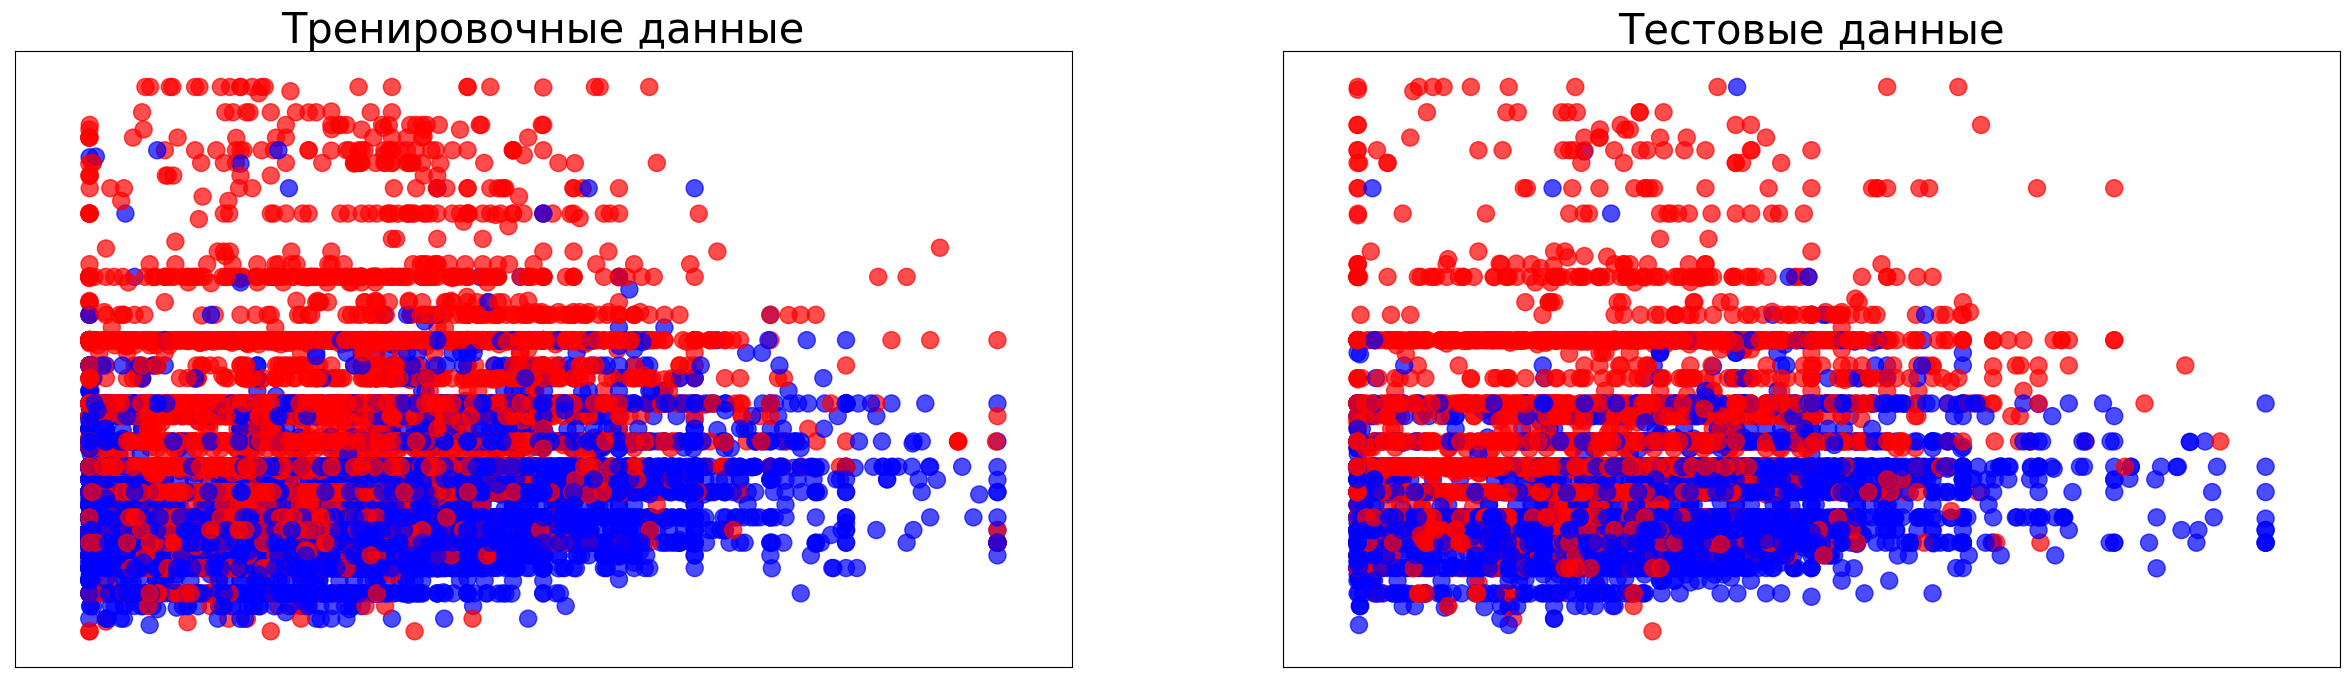

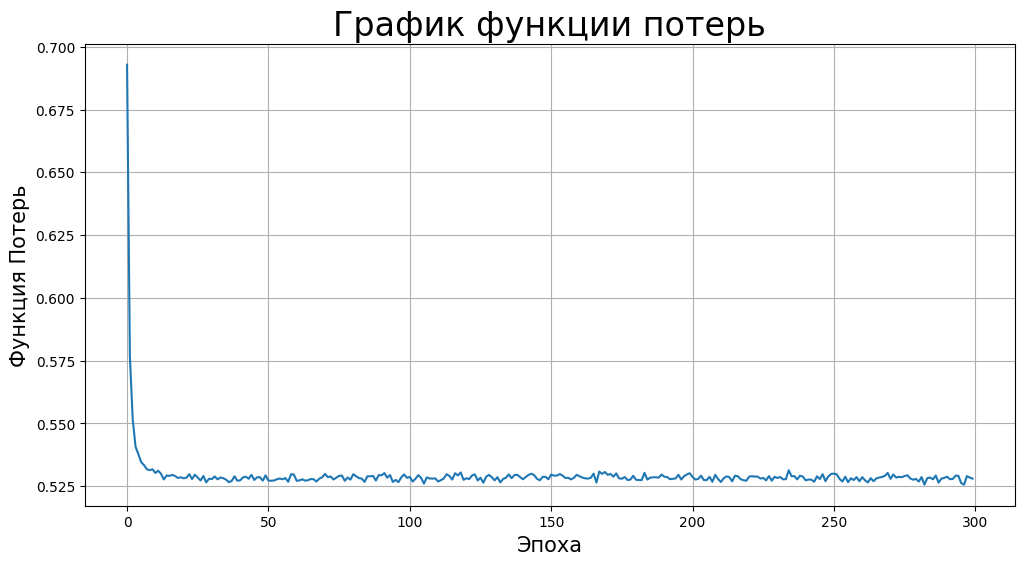

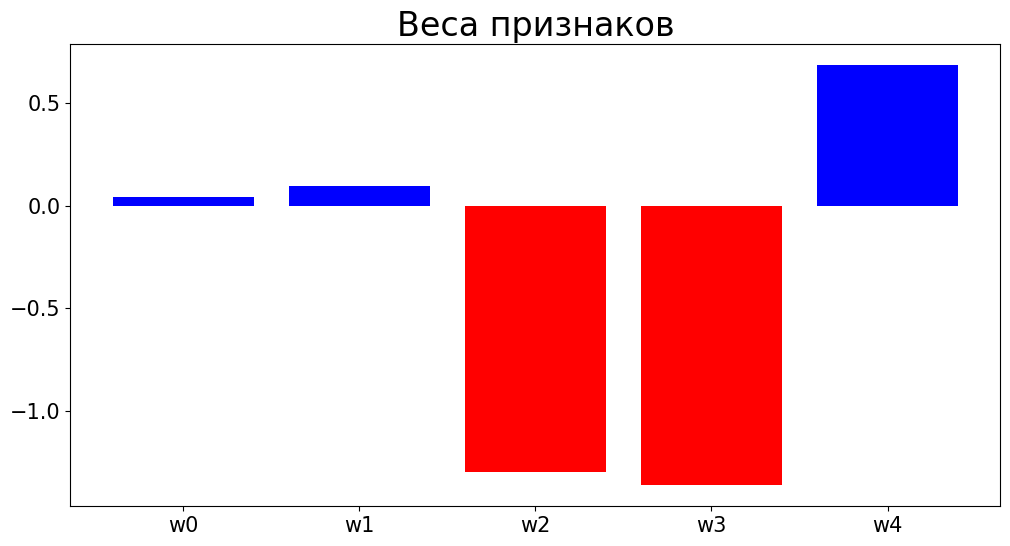

Accuracy:
Для тренировочной выборки 0.8133408558284871
Для тестовой выборки 0.8158161198865937
Метрики классификации
True Positives:0.8056	True Negatives:0.8306
False Positives:0.1944	False Negatives:0.1694
Accuracy:0.8158
Recall:0.8728	Precision:0.8056
f1 measure:0.8378


In [19]:
regr7 = LogisticRegression(learning_rate=0.4,epochs=300,batch_size=5000 )
regr7.classify(x, y, "Классификация данных Cars Moldova, "
                            "с использованием линейной модели без регуляризации")

#### Анализ
Функция потерь сходится достаточно быстро, но не к 0, есть пропуски и ложные срабатывания, метрики не очень высокие, но приемлимые. Параметр "Distance" оказывает наименьшее влияние результат, а параметры "Engine_capacity(cm3) " и "Price(euro)" - наибольшее.
Вывод: данный метод можно использовать для предсказания типа трансмиссии автомобилей на вторичном рынке Молдавии.

### Классификация данных с использованием квадратичной модели без регуляризации

Классификация данных Cars Moldova, с использованием квадратичной модели без регуляризации


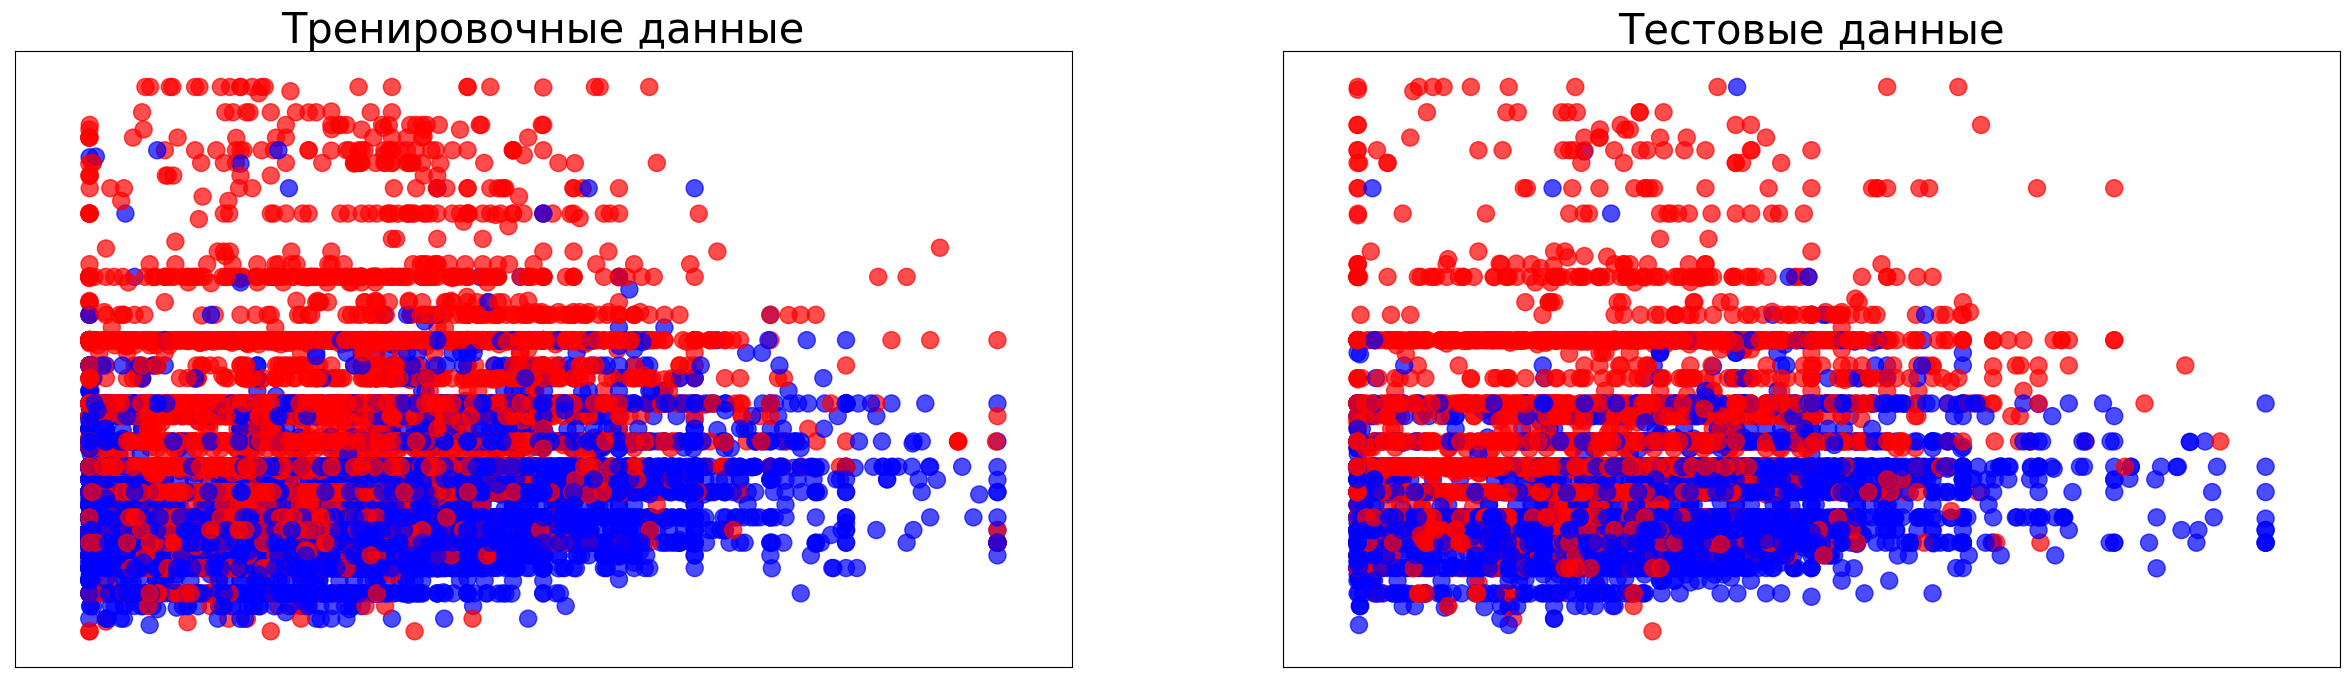

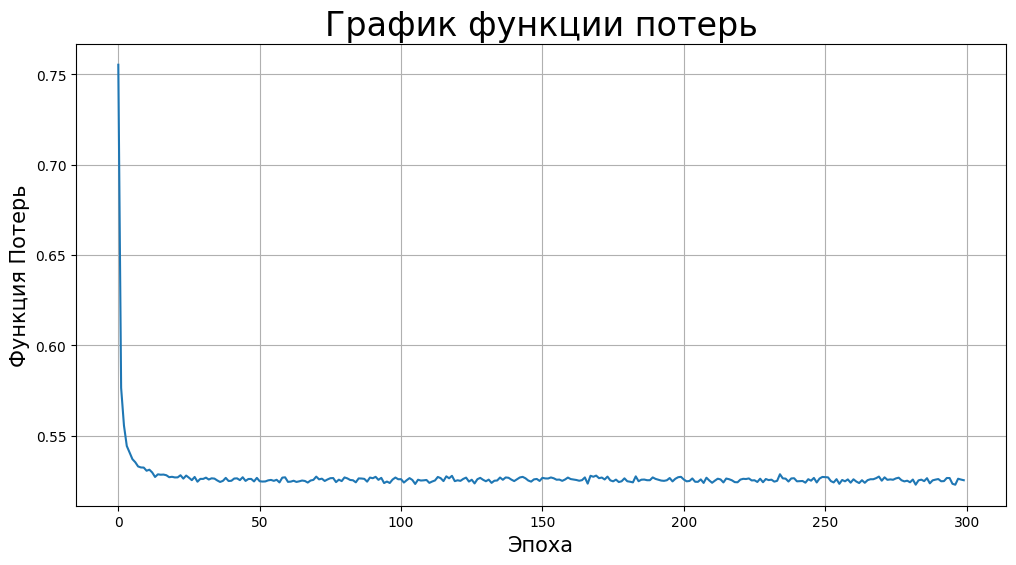

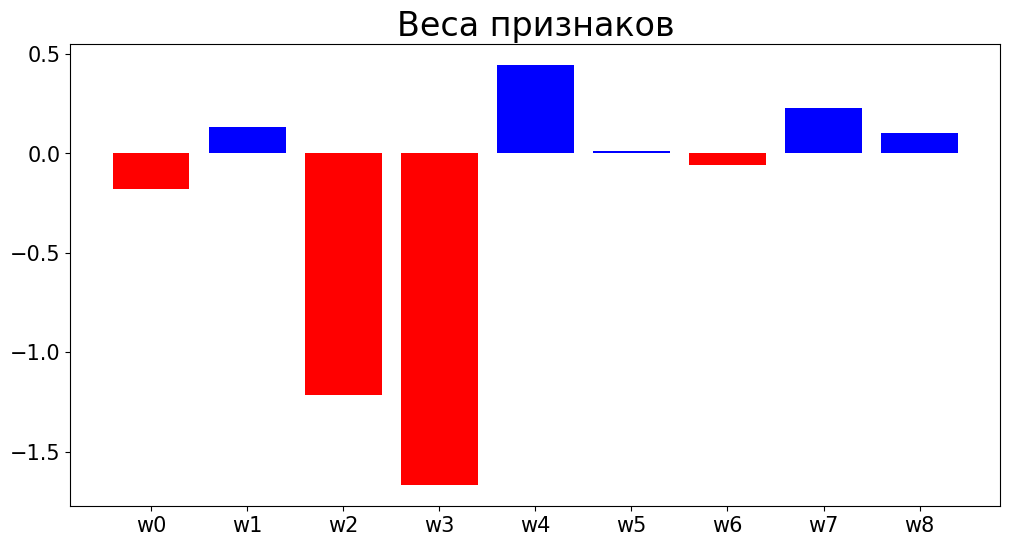

Accuracy:
Для тренировочной выборки 0.8133408558284871
Для тестовой выборки 0.8167274200081004
Метрики классификации
True Positives:0.8102	True Negatives:0.8258
False Positives:0.1898	False Negatives:0.1742
Accuracy:0.8167
Recall:0.8668	Precision:0.8102
f1 measure:0.8376


In [20]:
regr8 = LogisticRegression(learning_rate=0.4,epochs=300,batch_size=5000 )
regr8.classify(x, y, "Классификация данных Cars Moldova, "
                            "с использованием квадратичной модели без регуляризации", 2)

#### Анализ
Функция потерь сходится достаточно быстро, но не к 0, есть пропуски и ложные срабатывания, метрики не очень высокие, но приемлимые. Параметр "Distance" оказывает наименьшее влияние результат, а параметры "Engine_capacity(cm3) " и "Price(euro)" - наибольшее.
Из добавленных признаков наименьшее влияние оказывают квадраты расстояния, объема двигателя и возраста.  В целом добавление сложности модели не увеличило точности предсказания.
Вывод: данный метод не следует использовать для предсказания типа трансмиссии автомобилей на вторичном рынке Молдавии. Вместо него предпочтительней линейная модель.

### Классификация данных с использованием квадратичной модели с регуляризацией

Классификация данных Cars Moldova, с использованием квадратичной модели с регуляризацией


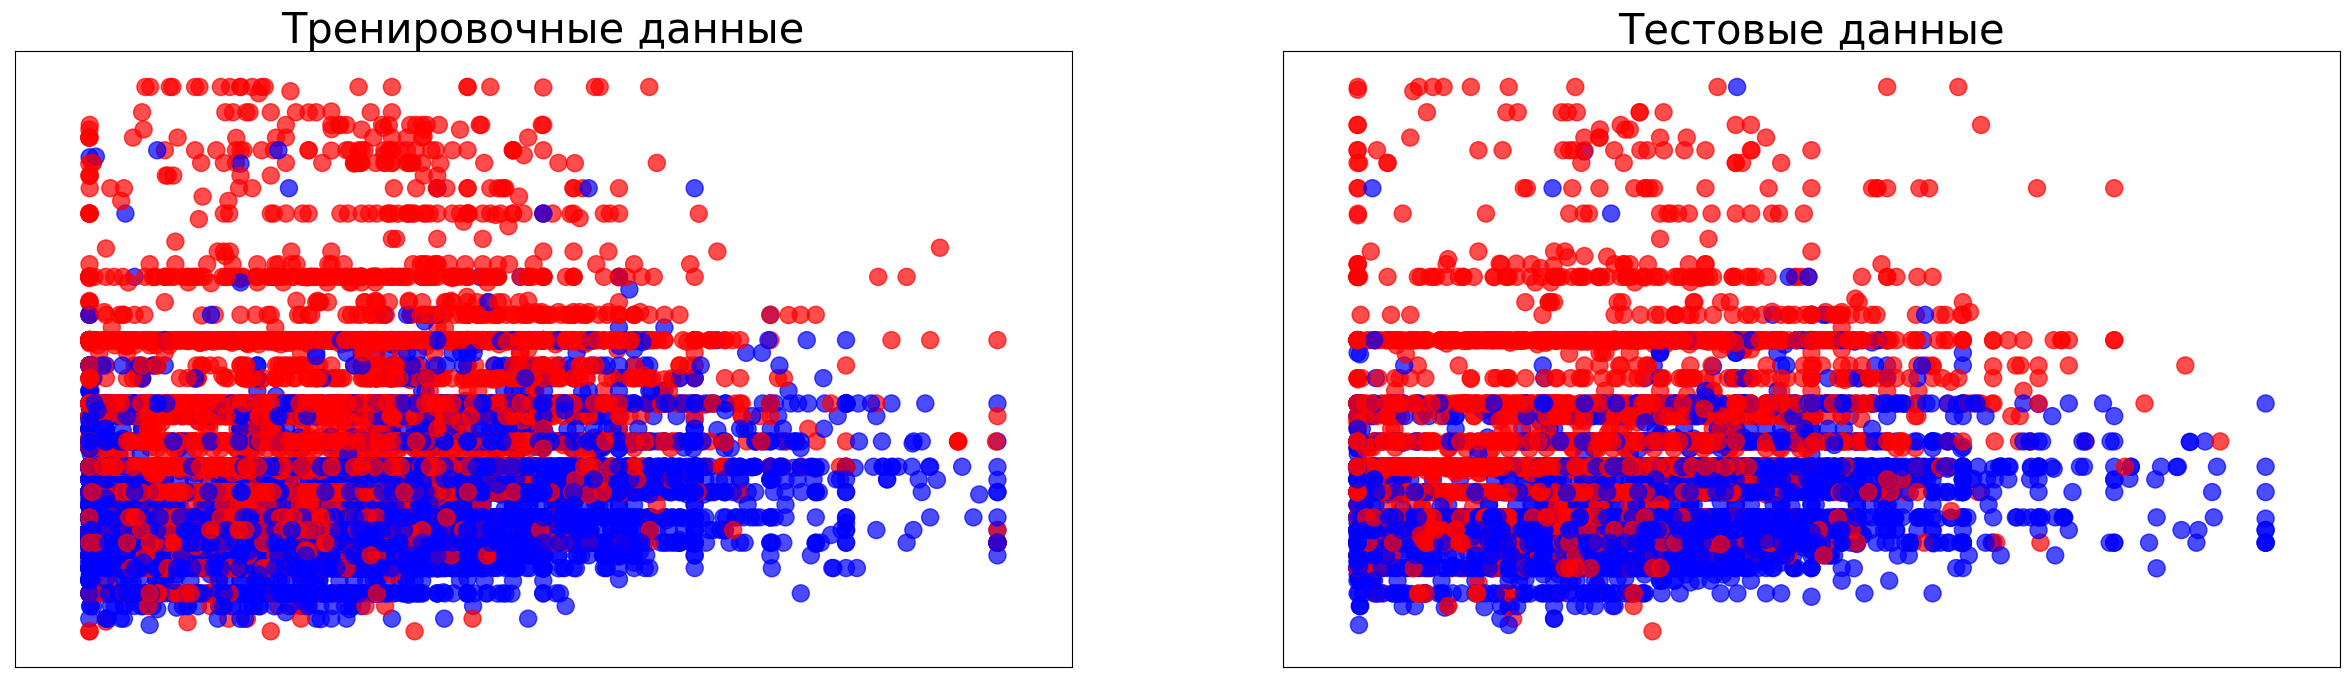

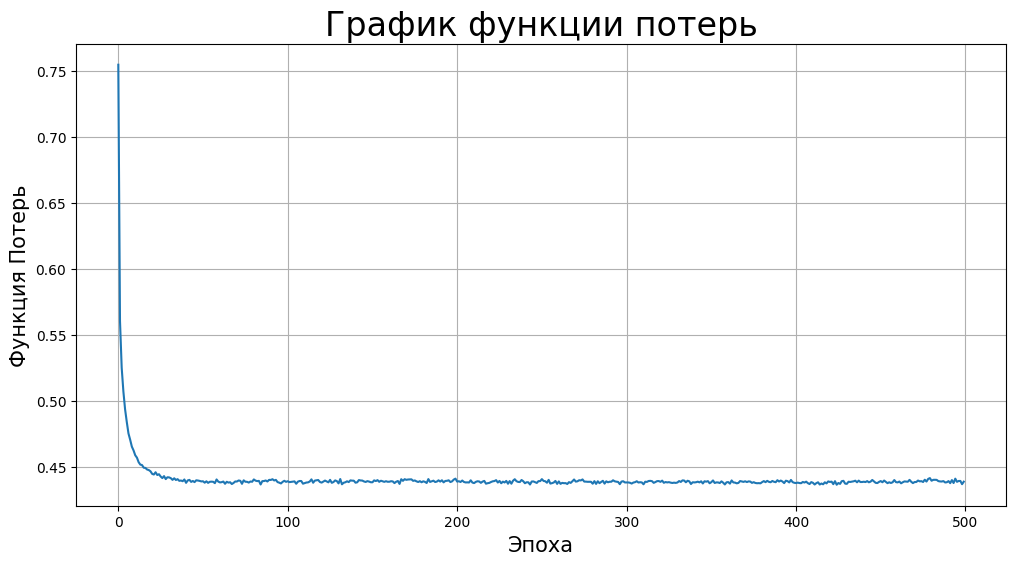

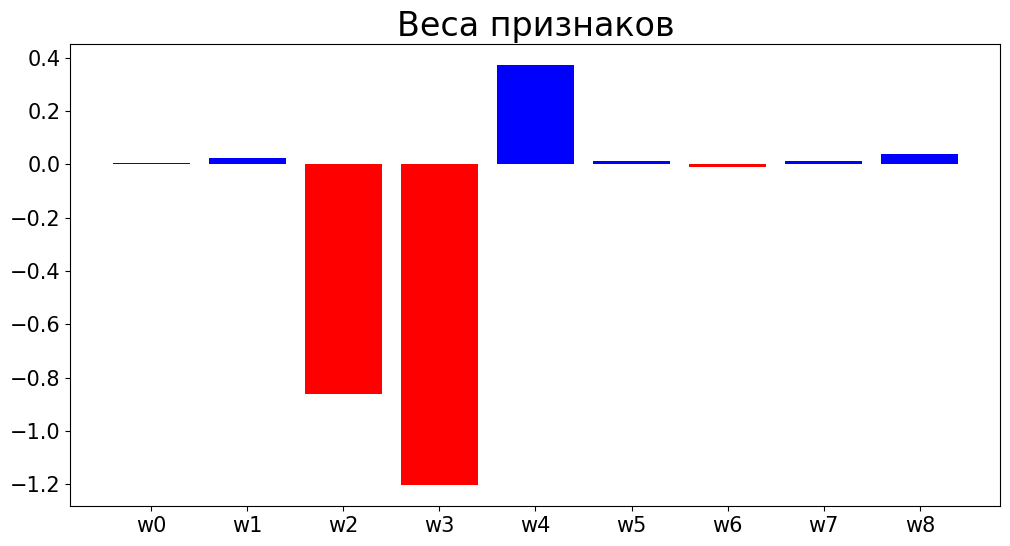

Accuracy:
Для тренировочной выборки 0.8122124815554206
Для тестовой выборки 0.8153098420413123
Метрики классификации
True Positives:0.7999	True Negatives:0.8386
False Positives:0.2001	False Negatives:0.1614
Accuracy:0.8153
Recall:0.8819	Precision:0.7999
f1 measure:0.8389


In [21]:
regr9 = LogisticRegression(learning_rate=0.4, epochs=500,batch_size=5000,  l1_penalty=.05 )
regr9.classify(x, y, "Классификация данных Cars Moldova, "
                            "с использованием квадратичной модели с регуляризацией",2)

#### Анализ
Функция потерь сходится достаточно быстро, но не к 0, есть пропуски и ложные срабатывания, метрики не очень высокие, но приемлимые. Параметр "Distance" оказывает наименьшее влияние результат, а параметры "Engine_capacity(cm3) " и "Price(euro)" - наибольшее.
Все добавленные признаки после регуляризации оказались незначимыми, что говорит о нецелесообразности увеличения сложности модели. Добавление сложности модели и регуляризации не увеличило точности предсказания.
Вывод: данный метод не следует использовать для предсказания типа трансмиссии автомобилей на вторичном рынке Молдавии. Вместо него предпочтительна линейная модель без регуляризации.


## Логистическая регрессия при использовании степенного преобразования для числовых признаков
### Загрузка данных


In [22]:
# Загрузка числовых стандартизованных данных
df_pt = pd.read_csv('./content/cars_moldova_hw1_df_pt.csv', delimiter = ',')
x_pt = df_pt.values
df_pt.tail()

Distance  Engine_capacity(cm3)  Price(euro)       Age
32913  0.574587              0.053121    -0.454476  0.940857
32914 -0.752099             -0.684590     0.076796 -1.011362
32915 -2.219265             -0.684590    -0.429379  0.066070
32916  1.720679              0.440833    -0.560232  0.475051
32917  1.189461             -0.684590    -0.560232  0.475051

### Классификация данных с использованием линейной модели без регуляризации

Классификация данных Cars Moldova, с использованием линейной модели без регуляризации


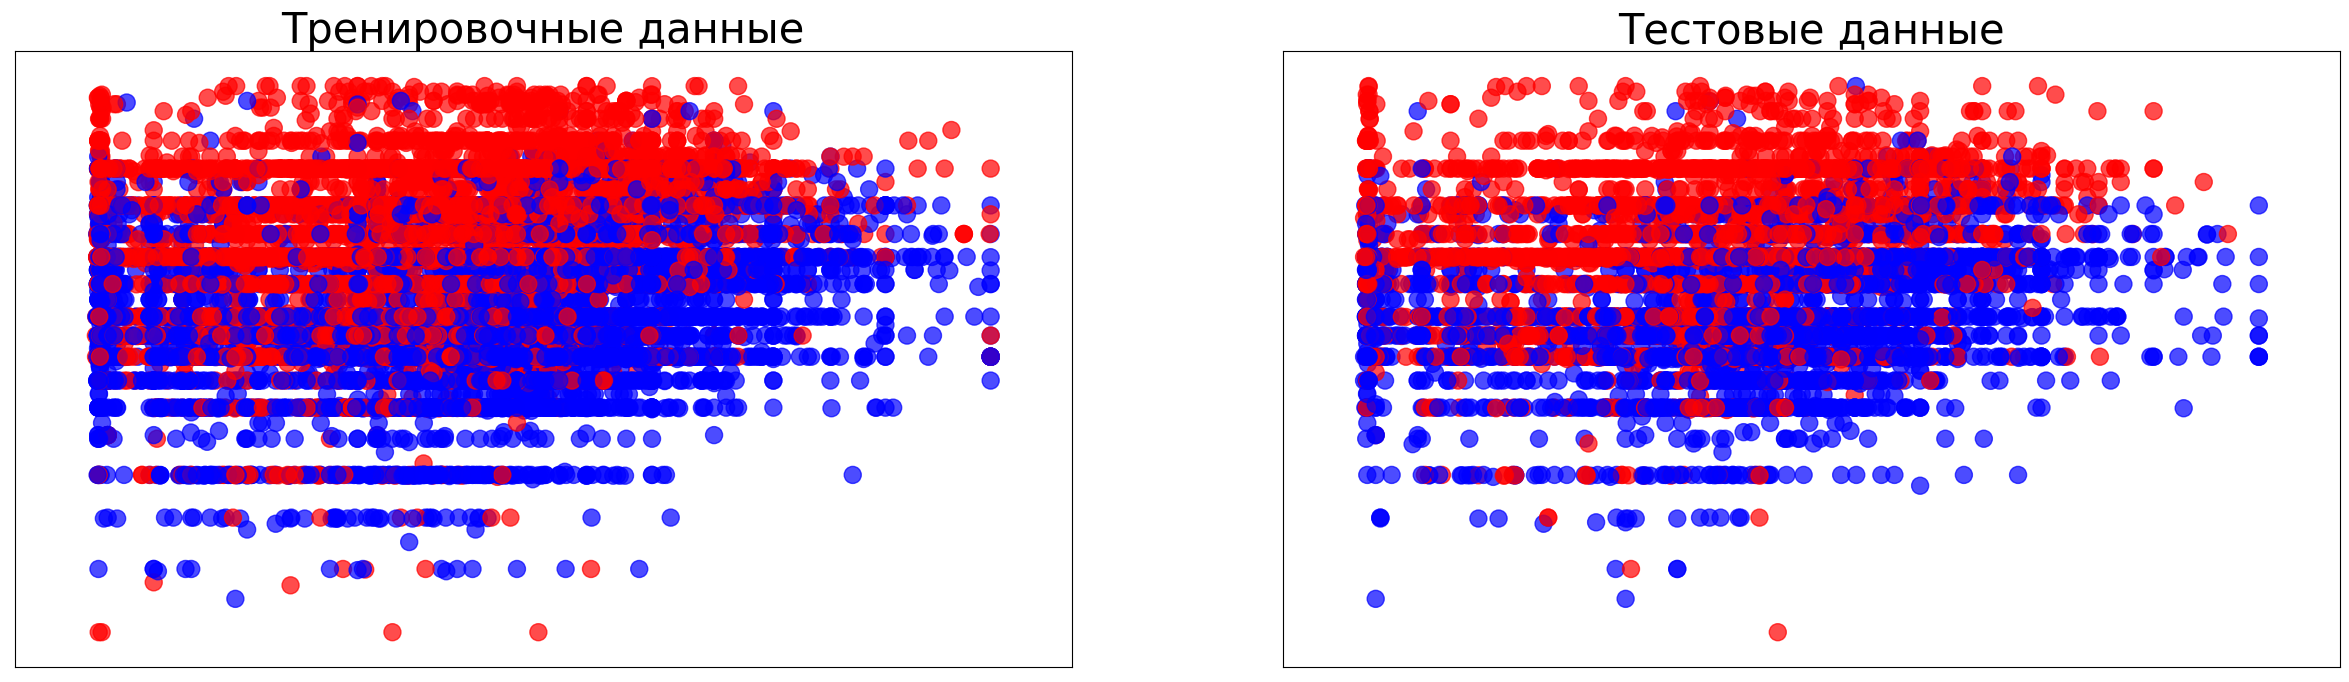

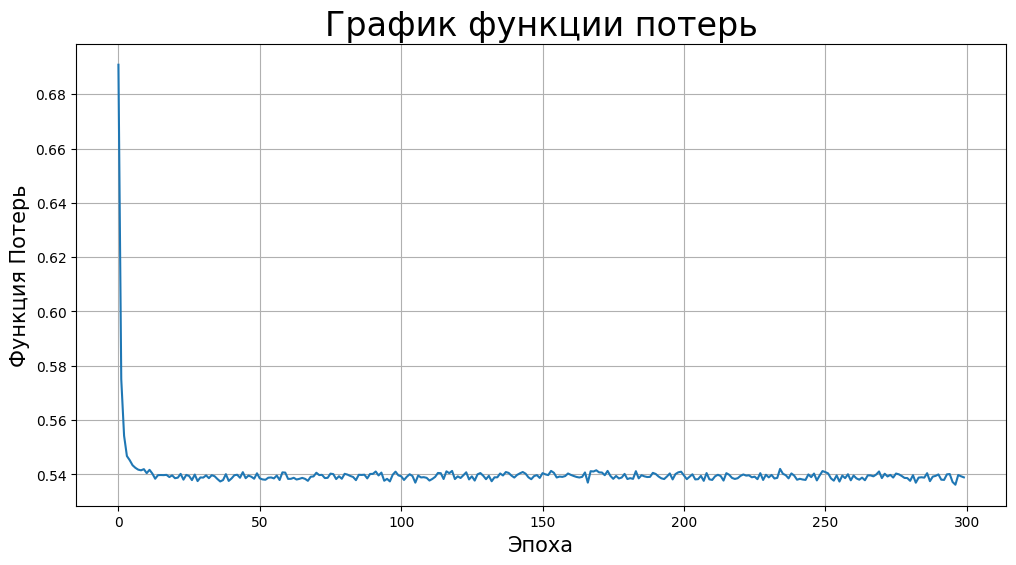

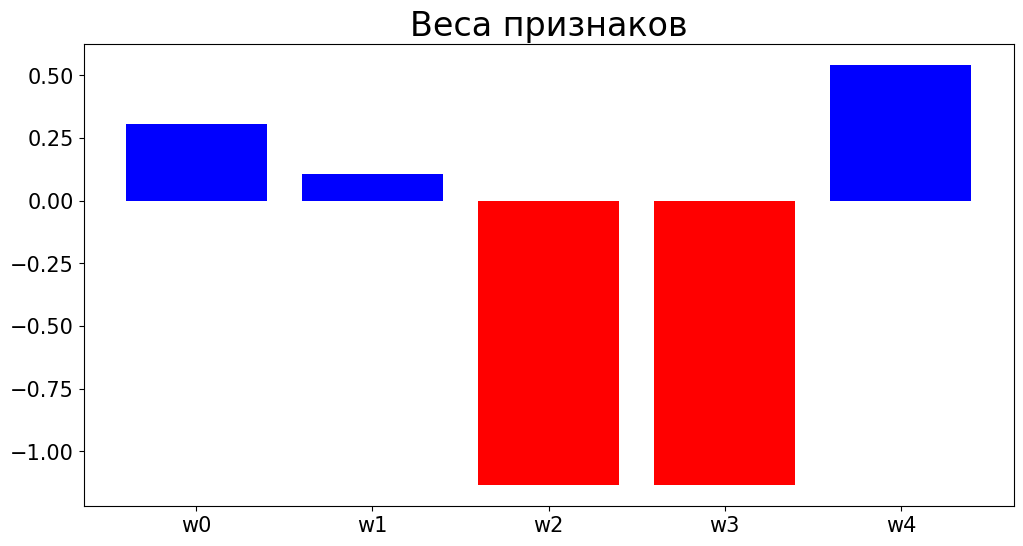

Accuracy:
Для тренировочной выборки 0.8104331221248156
Для тестовой выборки 0.8105508302956662
Метрики классификации
True Positives:0.8106	True Negatives:0.8105
False Positives:0.1894	False Negatives:0.1895
Accuracy:0.8106
Recall:0.8514	Precision:0.8106
f1 measure:0.8305


In [23]:
regr10 = LogisticRegression(learning_rate=0.4, epochs=300, batch_size=5000)
regr10.classify(x_pt, y, "Классификация данных Cars Moldova, "
                     "с использованием линейной модели без регуляризации")

#### Анализ
Функция потерь сходится достаточно быстро, но не к 0, есть пропуски и ложные срабатывания, метрики не очень высокие, но приемлимые. Параметр "Distance" оказывает наименьшее влияние результат, а параметры "Engine_capacity(cm3) " и "Price(euro)" - наибольшее.
Использование степенного преобразования для числовых признаков не дало никакого преимущества по сравнению со стандартизацией, и полностью ему аналогичен.
Вывод: данный метод можно использовать для предсказания типа трансмиссии автомобилей на вторичном рынке Молдавии.


## Добавление категориальных признаков

In [24]:
transformed_fields = ['Model','Make', 'Style', 'Brand_country', 'Age_group', 'Wear', 'Transmission_Manual']
df_numeric_encoded = df_ne.drop(columns = transformed_fields)
df_cat= pd.concat([df,df_numeric_encoded], axis = 1)
x_cat = df_cat.values
df_cat.tail()

Distance  Engine_capacity(cm3)  Price(euro)       Age  \
32913  0.528012             -0.156758    -0.579039  0.866971   
32914 -0.858773             -0.686971    -0.243899 -0.954742   
32915 -1.764008             -0.686971    -0.566149 -0.113951   
32916  2.006570              0.196717    -0.630599  0.306444   
32917  1.292784             -0.686971    -0.630599  0.306444   

       Fuel_type_Diesel  Fuel_type_Electric  Fuel_type_Hybrid  \
32913                 0                   0                 0   
32914                 1                   0                 0   
32915                 1                   0                 0   
32916                 1                   0                 0   
32917                 1                   0                 0   

       Fuel_type_Metan/Propan  Fuel_type_Petrol  Fuel_type_Plug-in Hybrid  
32913                       1                 0                         0  
32914                       0                 0                         0  
32915                       0                 0                         0  
32916                       0                 0                         0  
32917                       0                 0                         0

#### Классификация данных с использованием линейной модели без регуляризации

Классификация данных Cars Moldova, с использованием линейной модели без регуляризации


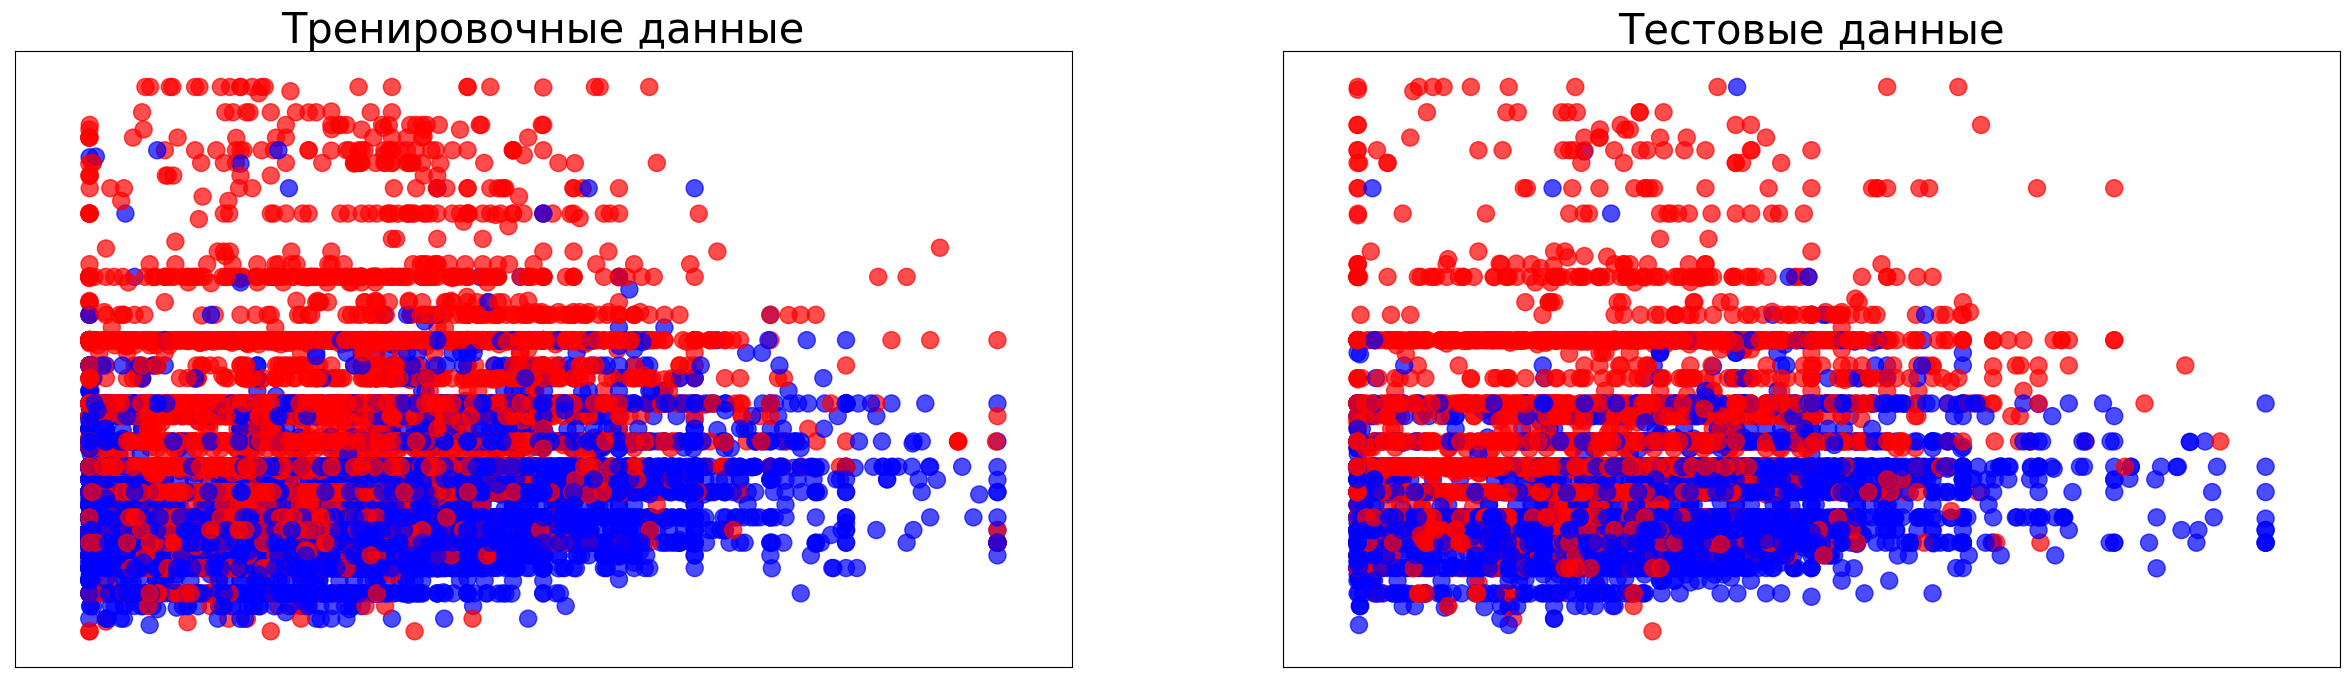

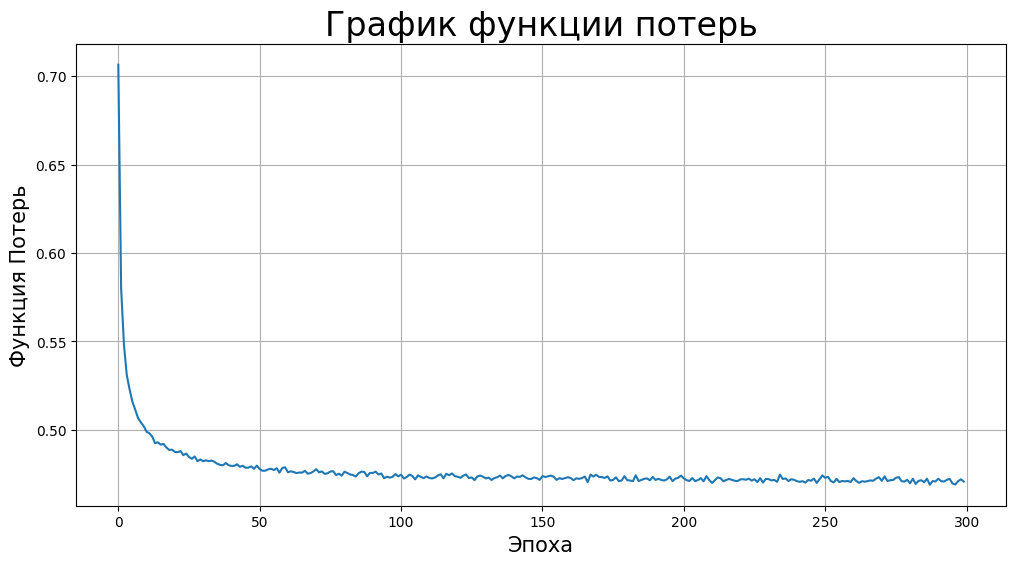

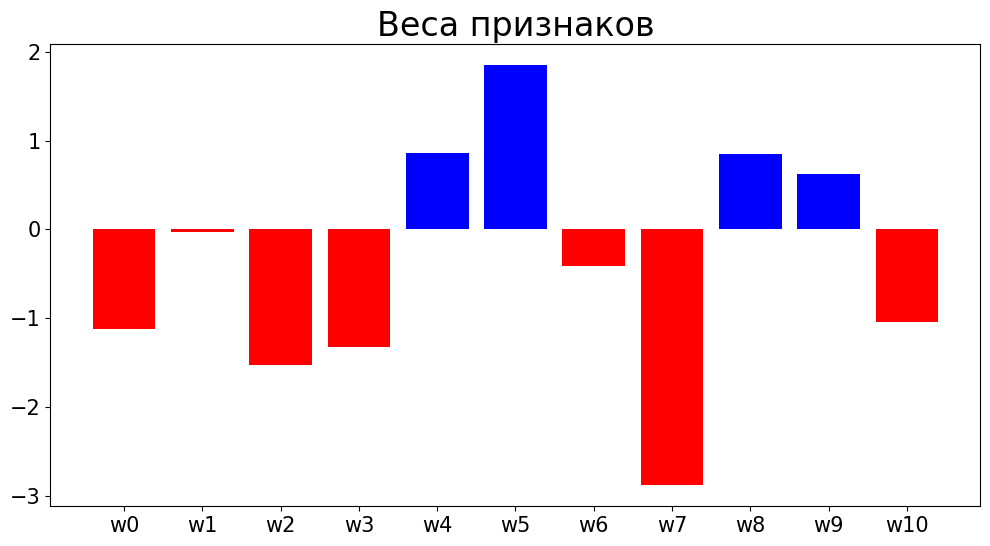

Accuracy:
Для тренировочной выборки 0.8357347452478083
Для тестовой выборки 0.8355609558525718
Метрики классификации
True Positives:0.8186	True Negatives:0.8607
False Positives:0.1814	False Negatives:0.1393
Accuracy:0.8356
Recall:0.8971	Precision:0.8186
f1 measure:0.8561


In [25]:
regr11 = LogisticRegression(learning_rate=0.4, epochs=300, batch_size=5000)
regr11.classify(x_cat, y, "Классификация данных Cars Moldova, "
                     "с использованием линейной модели без регуляризации")

#### Анализ
Функция потерь сходится достаточно быстро, но не к 0, есть пропуски и ложные срабатывания, метрики не очень высокие, но приемлимые. Параметр "Distance" оказывает наименьшее влияние результат, а параметры "Engine_capacity(cm3) ",  "Price(euro)", "Fuel_type_Diesel" и - "Fuel_type_Hybrid" - наибольшее.
Добавление категориальных признаков позволило немного повысить точность предсказания, однако добавилось ряд признаков, не имеющих большого влияния на результат. Оценим их.

### Классификация данных с использованием линейной модели с регуляризацией

Классификация данных Cars Moldova, с использованием линейной модели с регуляризацией


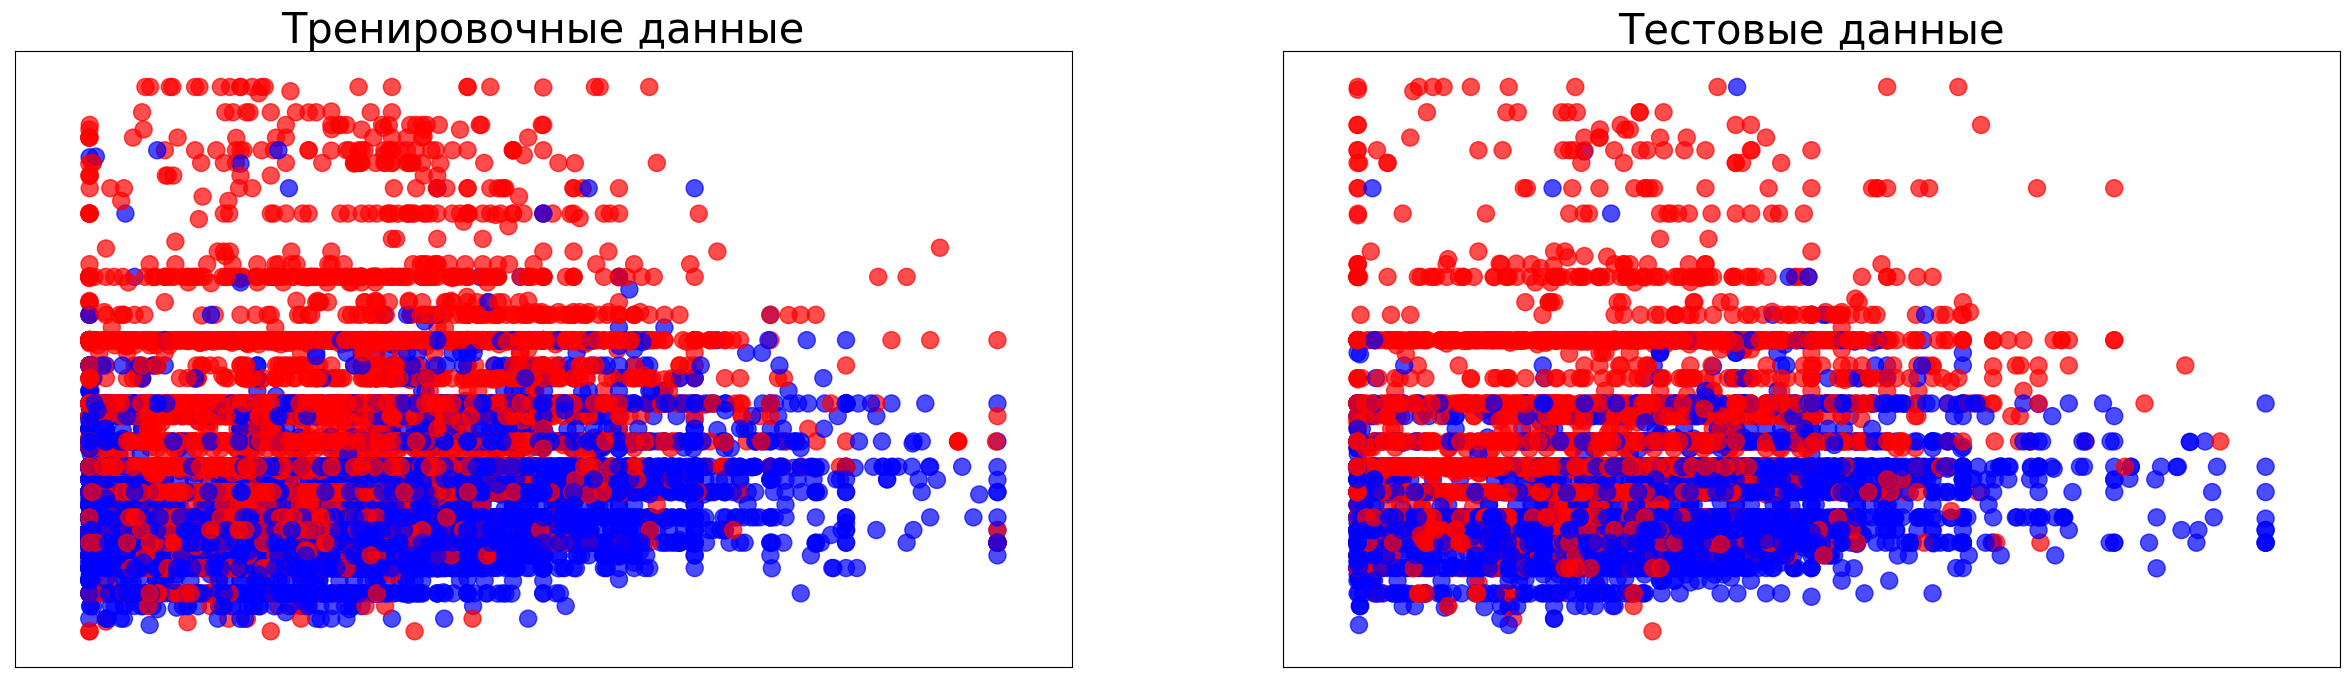

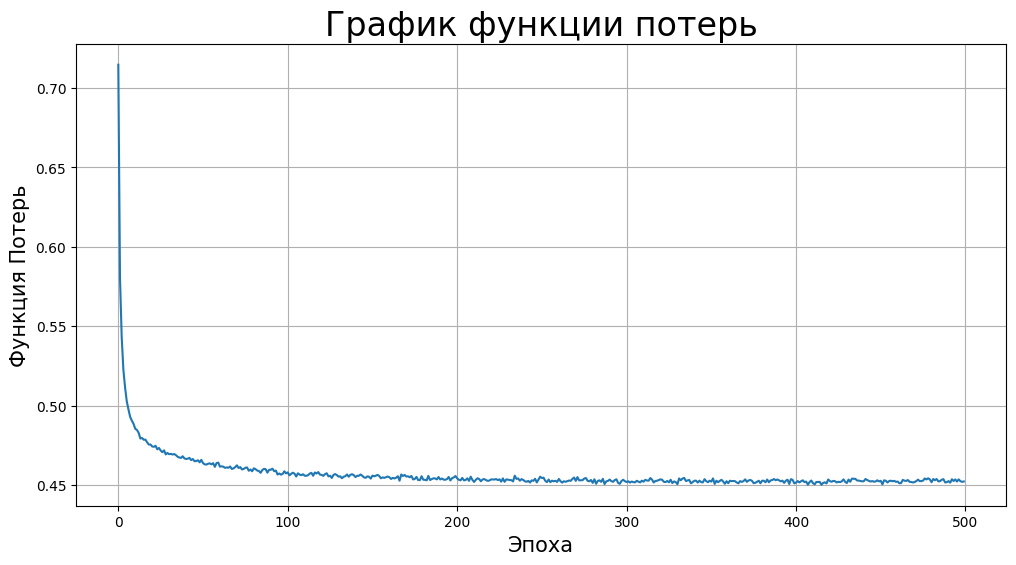

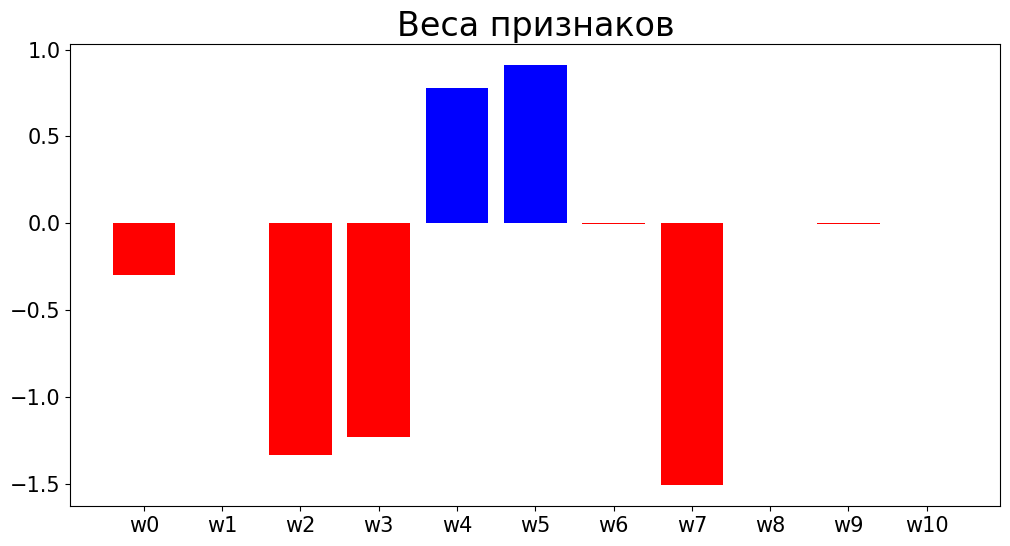

Accuracy:
Для тренировочной выборки 0.834389375922229
Для тестовой выборки 0.8345484001620089
Метрики классификации
True Positives:0.8161	True Negatives:0.8623
False Positives:0.1839	False Negatives:0.1377
Accuracy:0.8345
Recall:0.8991	Precision:0.8161
f1 measure:0.8556


In [26]:
regr12 = LogisticRegression(learning_rate=0.4, epochs=500,batch_size=5000,  l1_penalty=.01 )
regr12.classify(x_cat, y, "Классификация данных Cars Moldova, "
                            "с использованием линейной модели с регуляризацией")

#### Анализ
Функция потерь сходится достаточно быстро, но не к 0, есть пропуски и ложные срабатывания, метрики не очень высокие, но приемлимые. Параметры "Distance", "Fuel_type_Electric", "Fuel_type_Metan/Propan", "Fuel_type_Petrol", "Fuel_type_Plug-in Hybrid" оказывает незначительное влияние результат, поэтому имеет смысл их удалить.
Добавление регуляризации немного снизило точность предсказания.

### Уменьшение числа признаков

In [27]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32918 entries, 0 to 32917
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Distance                  32918 non-null  float64
 1   Engine_capacity(cm3)      32918 non-null  float64
 2   Price(euro)               32918 non-null  float64
 3   Age                       32918 non-null  float64
 4   Fuel_type_Diesel          32918 non-null  int64  
 5   Fuel_type_Electric        32918 non-null  int64  
 6   Fuel_type_Hybrid          32918 non-null  int64  
 7   Fuel_type_Metan/Propan    32918 non-null  int64  
 8   Fuel_type_Petrol          32918 non-null  int64  
 9   Fuel_type_Plug-in Hybrid  32918 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 2.5 MB


In [28]:
drop_columns=['Distance', 'Fuel_type_Electric', 'Fuel_type_Metan/Propan', 'Fuel_type_Petrol', 'Fuel_type_Plug-in Hybrid']
df_cat_drop= df_cat.drop(columns = [*drop_columns])
x_cat = df_cat_drop.values
df_cat_drop.tail()

Engine_capacity(cm3)  Price(euro)       Age  Fuel_type_Diesel  \
32913             -0.156758    -0.579039  0.866971                 0   
32914             -0.686971    -0.243899 -0.954742                 1   
32915             -0.686971    -0.566149 -0.113951                 1   
32916              0.196717    -0.630599  0.306444                 1   
32917             -0.686971    -0.630599  0.306444                 1   

       Fuel_type_Hybrid  
32913                 0  
32914                 0  
32915                 0  
32916                 0  
32917                 0

### Классификация данных с использованием линейной модели с уменьшенным числом признаков и  регуляризацией

Классификация данных Cars Moldova,  с уменьшенным числом признаков и  регуляризацией


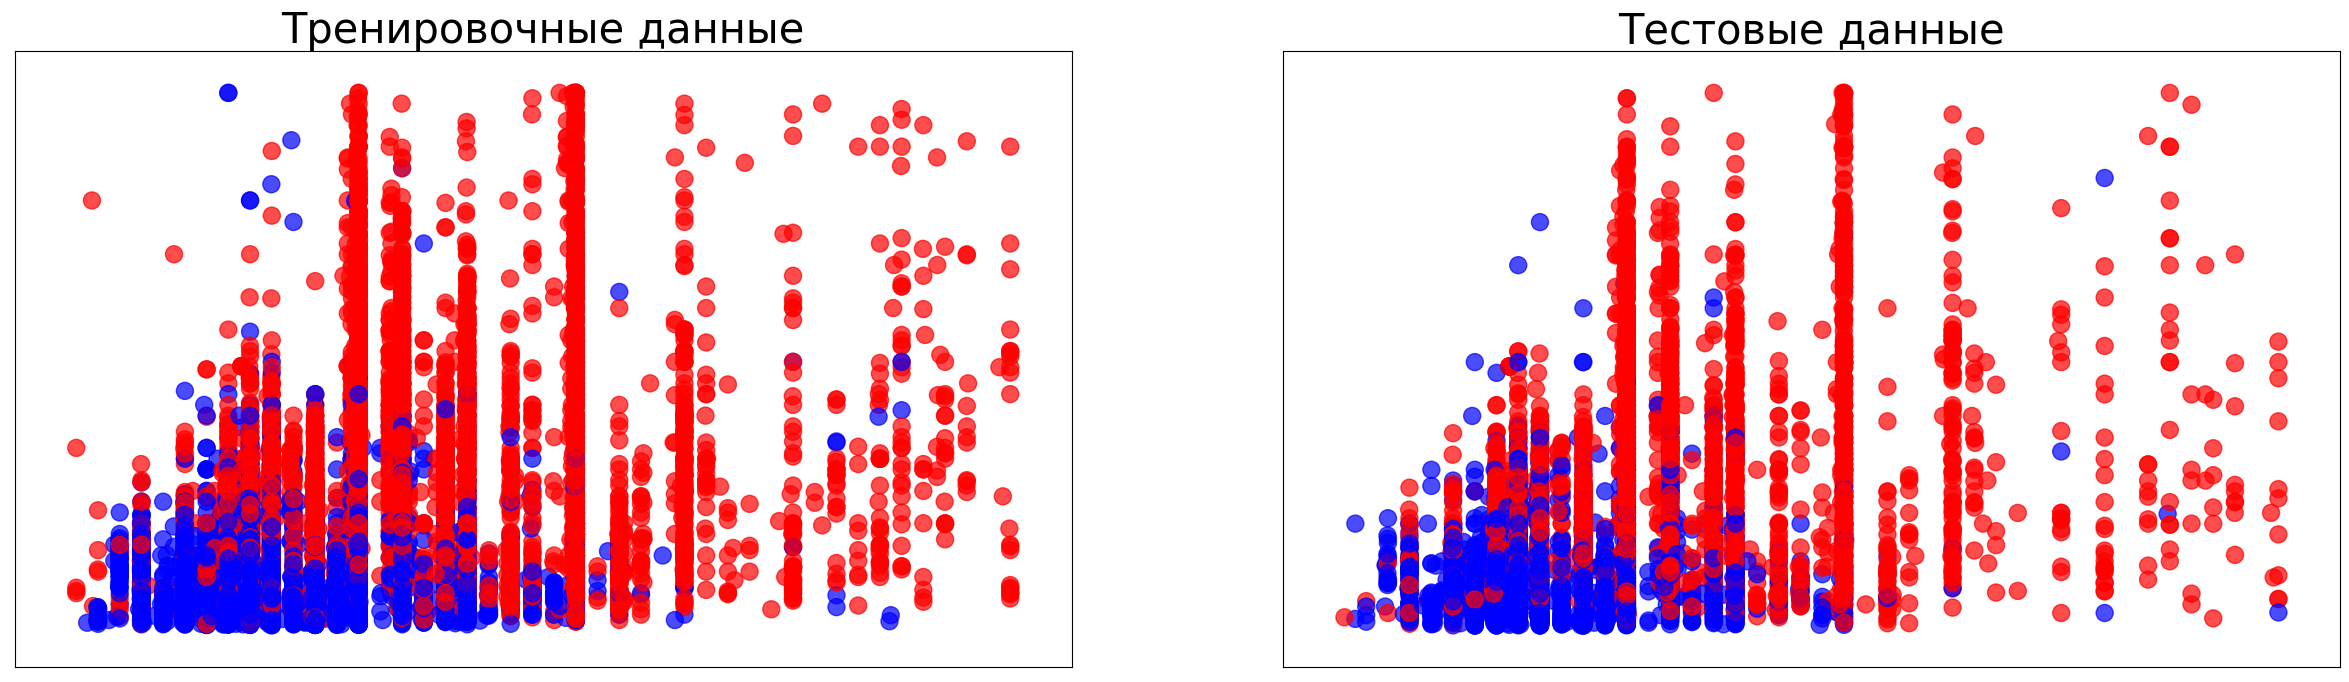

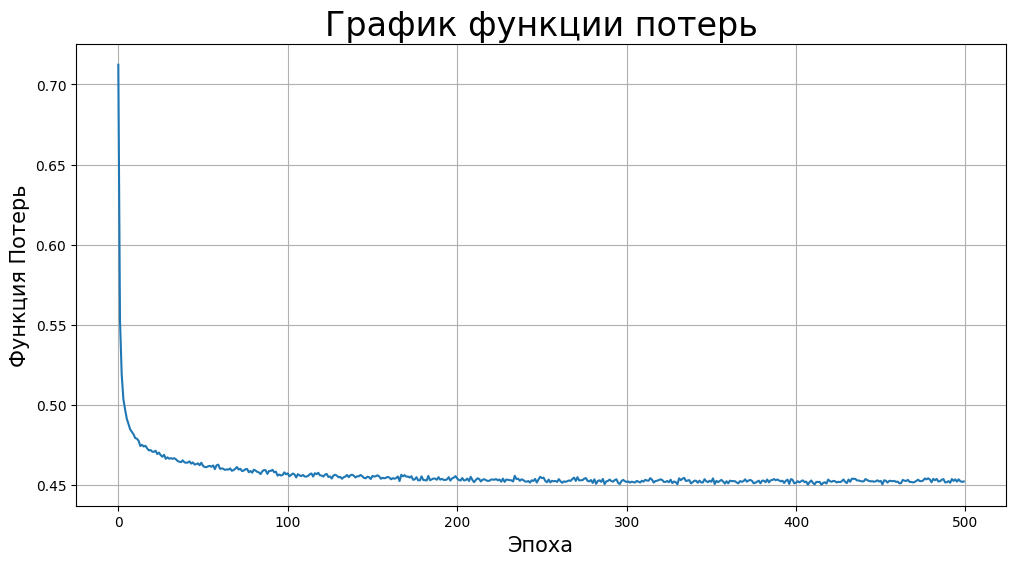

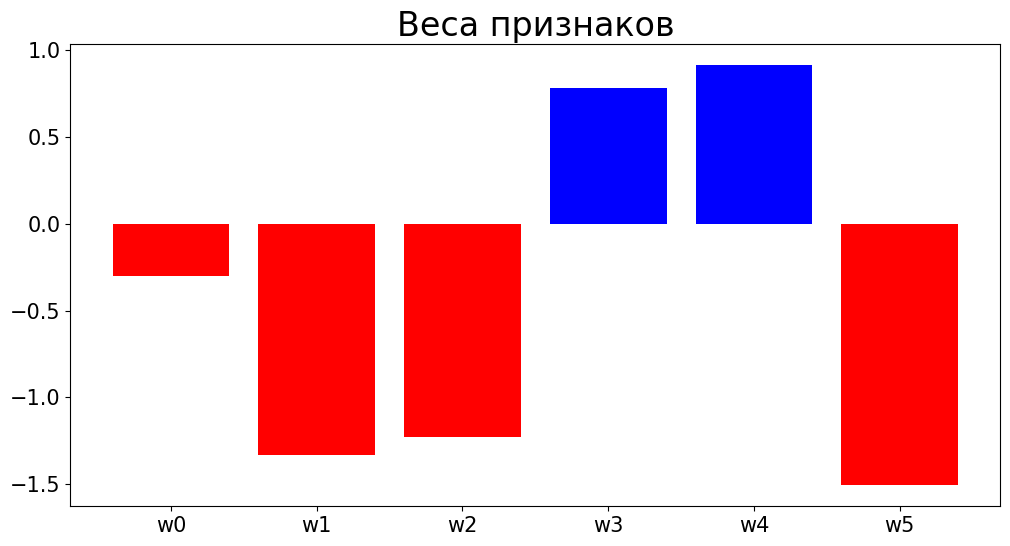

Accuracy:
Для тренировочной выборки 0.8345195729537367
Для тестовой выборки 0.8345484001620089
Метрики классификации
True Positives:0.8162	True Negatives:0.8621
False Positives:0.1838	False Negatives:0.1379
Accuracy:0.8345
Recall:0.8990	Precision:0.8162
f1 measure:0.8556


In [29]:
regr13 = LogisticRegression(learning_rate=0.4, epochs=500,batch_size=5000,  l1_penalty=.01 )
regr13.classify(x_cat, y, "Классификация данных Cars Moldova, "
                            " с уменьшенным числом признаков и  регуляризацией")

In [30]:
df_cat_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32918 entries, 0 to 32917
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Engine_capacity(cm3)  32918 non-null  float64
 1   Price(euro)           32918 non-null  float64
 2   Age                   32918 non-null  float64
 3   Fuel_type_Diesel      32918 non-null  int64  
 4   Fuel_type_Hybrid      32918 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 1.3 MB


#### Анализ
Функция потерь сходится достаточно быстро, но не к 0, есть пропуски и ложные срабатывания, метрики не очень высокие, но приемлимые. В качестве значимых признаков в модели остались: объем двигателя, цена, возраст автомобиля, тип топлива - дизель и гибрид.  Точность предсказания при добавлении категориальных признаков "тип топлива дизель" и "тип топлива гибрид" и регуляризации немного повысилась.
Вывод: данную модель можно считать предпочтительной для предсказания типа трансмиссии автомобилей на вторичном рынке Молдавии.
